Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

D:\miniconda\envs\ml4t\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ImportError: cannot import name 'SettingWithCopyWarning' from 'pandas.core.common' (C:\Users\masta\AppData\Roaming\Python\Python39\site-packages\pandas\core\common.py)

# Chapter 4 - Exploring Financial Time Series Data

이전 장에서는 금융 시계열 데이터를 전처리하고 시각적으로 탐색하는 방법에 대해 배웠습니다. 이번에는 알고리즘과/또는 통계적 검정을 사용하여 잠재적인 문제(예: 이상치)를 자동으로 식별하고, 데이터에서 트렌드나 기타 패턴(예: 평균 회귀)의 존재를 분석할 것입니다. 또한 자산 수익률의 스타일화된 사실(stylized facts)에 대해 더 깊이 다룰 것입니다. 이상치 탐지는 이러한 스타일화된 사실과 함께 금융 데이터 작업에서 특히 중요합니다. 자산 가격을 기반으로 모델/전략을 구축하려면 수익률의 역학을 정확하게 포착할 수 있어야 합니다. 이 장에서 설명하는 대부분의 기술은 금융 시계열에만 국한되지 않고 다른 도메인에서도 효과적으로 사용할 수 있습니다. 이번 장에서는 다음과 같은 내용을 다룰 것입니다:

1. 롤링 통계를 사용한 이상치 탐지
2. Hampel 필터를 사용한 이상치 탐지
3. 시계열에서 변화점 감지
4. 시계열에서 트렌드 감지
5. Hurst 지수를 사용한 시계열 패턴 감지
6. 자산 수익률의 스타일화된 사실 조사

## 4.1 Outlier detection using rolling statistics

**롤링 통계를 사용한 이상치 탐지**

어떤 종류의 데이터든 작업할 때, 대다수와 상당히 다른 관측값, 즉 이상치를 자주 만나게 됩니다. 금융 도메인에서 이상치는 잘못된 가격, 금융 시장에서 발생한 주요 사건, 또는 데이터 처리 과정에서의 오류로 인해 발생할 수 있습니다. 많은 머신 러닝 알고리즘과 통계적 접근법은 이상치에 크게 영향을 받아 잘못된 또는 편향된 결과를 초래할 수 있습니다. 따라서 모델을 만들기 전에 이상치를 식별하고 처리해야 합니다. 

이 장에서는 특정 관측값이 다른 관측값에 비해 눈에 띄는지를 조사하는 포인트 이상치 탐지에 중점을 둘 것입니다. 데이터 전체 시퀀스를 이상으로 식별할 수 있는 다양한 알고리즘이 있지만, 이번 레시피에서는 롤링 평균과 표준 편차를 기반으로 이상치를 감지하는 비교적 간단한 필터 방식 접근법을 다룰 것입니다. 우리는 2019년부터 2020년까지의 Tesla 주가를 사용할 것입니다.

### How to do it...

1. Import the libraries:

라이브러리를 임포트한 후, 

In [4]:
import pandas as pd 
import yfinance as yf

2. Download Tesla's stock prices from 2019-2020 and calculate simple returns:

Tesla의 주가를 다운로드하고 수익률을 계산한 뒤, 추가 분석을 위해 수익률이 있는 단일 열만 남겼습니다.

In [5]:
df = yf.download("TSLA", 
                 start="2019-01-01", 
                 end="2020-12-31",
                 progress=False)

df["rtn"] = df["Adj Close"].pct_change()
df = df[["rtn"]].copy()
df.head()


,rtn
Date,
2019-01-02,NaN
2019-01-03,-0.031472
2019-01-04,0.057697
2019-01-07,0.054361
2019-01-08,0.001164


3. Calculate the rolling mean and standard deviation:

이상치를 식별하기 위해 21일 롤링 윈도우를 사용하여 이동 통계를 계산하는 것부터 시작했습니다. 21일을 사용한 이유는 한 달에 평균적으로 21일의 거래일이 있기 때문이며, 이 예제에서는 일일 데이터를 사용합니다. 그러나 다른 값을 선택할 수도 있으며, 그에 따라 이동 평균이 변화에 더 빠르게/느리게 반응할 것입니다. 특정 사례에 더 의미가 있다고 생각되면 (지수적으로) 가중된 이동 평균을 사용할 수도 있습니다.

이동 통계를 구현하기 위해 pandas DataFrame의 rolling 및 agg 메서드를 조합하여 사용했습니다. 통계를 계산한 후, 분석을 단순화하기 위해 MultiIndex의 한 레벨을 제거했습니다. 롤링 윈도우를 적용할 때 이전 21개의 관측값을 사용하여 통계를 계산했습니다. 따라서 첫 번째 값은 DataFrame의 22번째 행에서 사용할 수 있습니다. 이 접근법을 사용함으로써 미래 정보를 알고리즘에 "누출"하지 않도록 했습니다. 그러나 경우에 따라 이러한 누출이 큰 문제가 되지 않는다고 생각될 수도 있습니다. 그런 경우, 중앙에 위치한 윈도우를 사용하고 싶을 수 있습니다. 동일한 윈도우 크기를 사용하여 과거 10개 관측값, 현재 관측값, 그리고 다음 10개의 미래 데이터 포인트를 고려할 수 있습니다. 이를 위해 rolling 메서드의 center 인수를 사용할 수 있습니다.

In [6]:
df_rolling = df[["rtn"]].rolling(window=21) \
                        .agg(["mean", "std"])
df_rolling.columns = df_rolling.columns.droplevel()

4. Join the rolling data back to the initial DataFrame:

4단계에서는 롤링 통계를 원래 DataFrame에 다시 결합했습니다.

In [7]:
df = df.join(df_rolling)
df.head()

,rtn,mean,std
Date,,,
2019-01-02,NaN,NaN,NaN
2019-01-03,-0.031472,NaN,NaN
2019-01-04,0.057697,NaN,NaN
2019-01-07,0.054361,NaN,NaN
2019-01-08,0.001164,NaN,NaN


5. Calculate the upper and lower thresholds:

그런 다음 상단 및 하단 결정 임계값을 포함하는 추가 열을 생성했습니다. 우리는 롤링 평균 위/아래로 3 표준 편차를 경계로 사용하기로 결정했습니다. 이 경계를 넘어서는 모든 관측값은 이상치로 간주되었습니다. 필터링 알고리즘의 논리가 주식 수익률이 정규 분포를 따른다는 가정에 기반하고 있음을 염두에 두어야 합니다. 이 장의 후반부에서 이 가정이 경험적으로 성립하지 않는다는 것을 보게 될 것입니다.

In [8]:
N_SIGMAS = 3
df["upper"] = df["mean"] + N_SIGMAS * df["std"]
df["lower"] = df["mean"] - N_SIGMAS * df["std"]

6. Identify the outliers using the previously calculated thresholds:

우리는 위 조건을 6단계에서 별도의 열로 코딩했습니다.

In [9]:
df["outlier"] = (
    (df["rtn"] > df["upper"]) | (df["rtn"] < df["lower"])
)

7. Plot the returns together with the thresholds and mark the outliers:

마지막 단계에서는 수익률 시리즈를 상/하단 결정 임계값과 함께 시각화하고, 이상치는 검은 점으로 표시했습니다. 플롯을 더 읽기 쉽게 만들기 위해 범례를 플로팅 영역 밖으로 이동시켰습니다. 실제 사례에서는 이상치를 식별하는 것뿐만 아니라, 허용 가능한 최대/최소 값으로 한정하거나, 보간된 값으로 대체하거나, 또는 다른 가능한 접근법을 사용하여 처리해야 합니다.

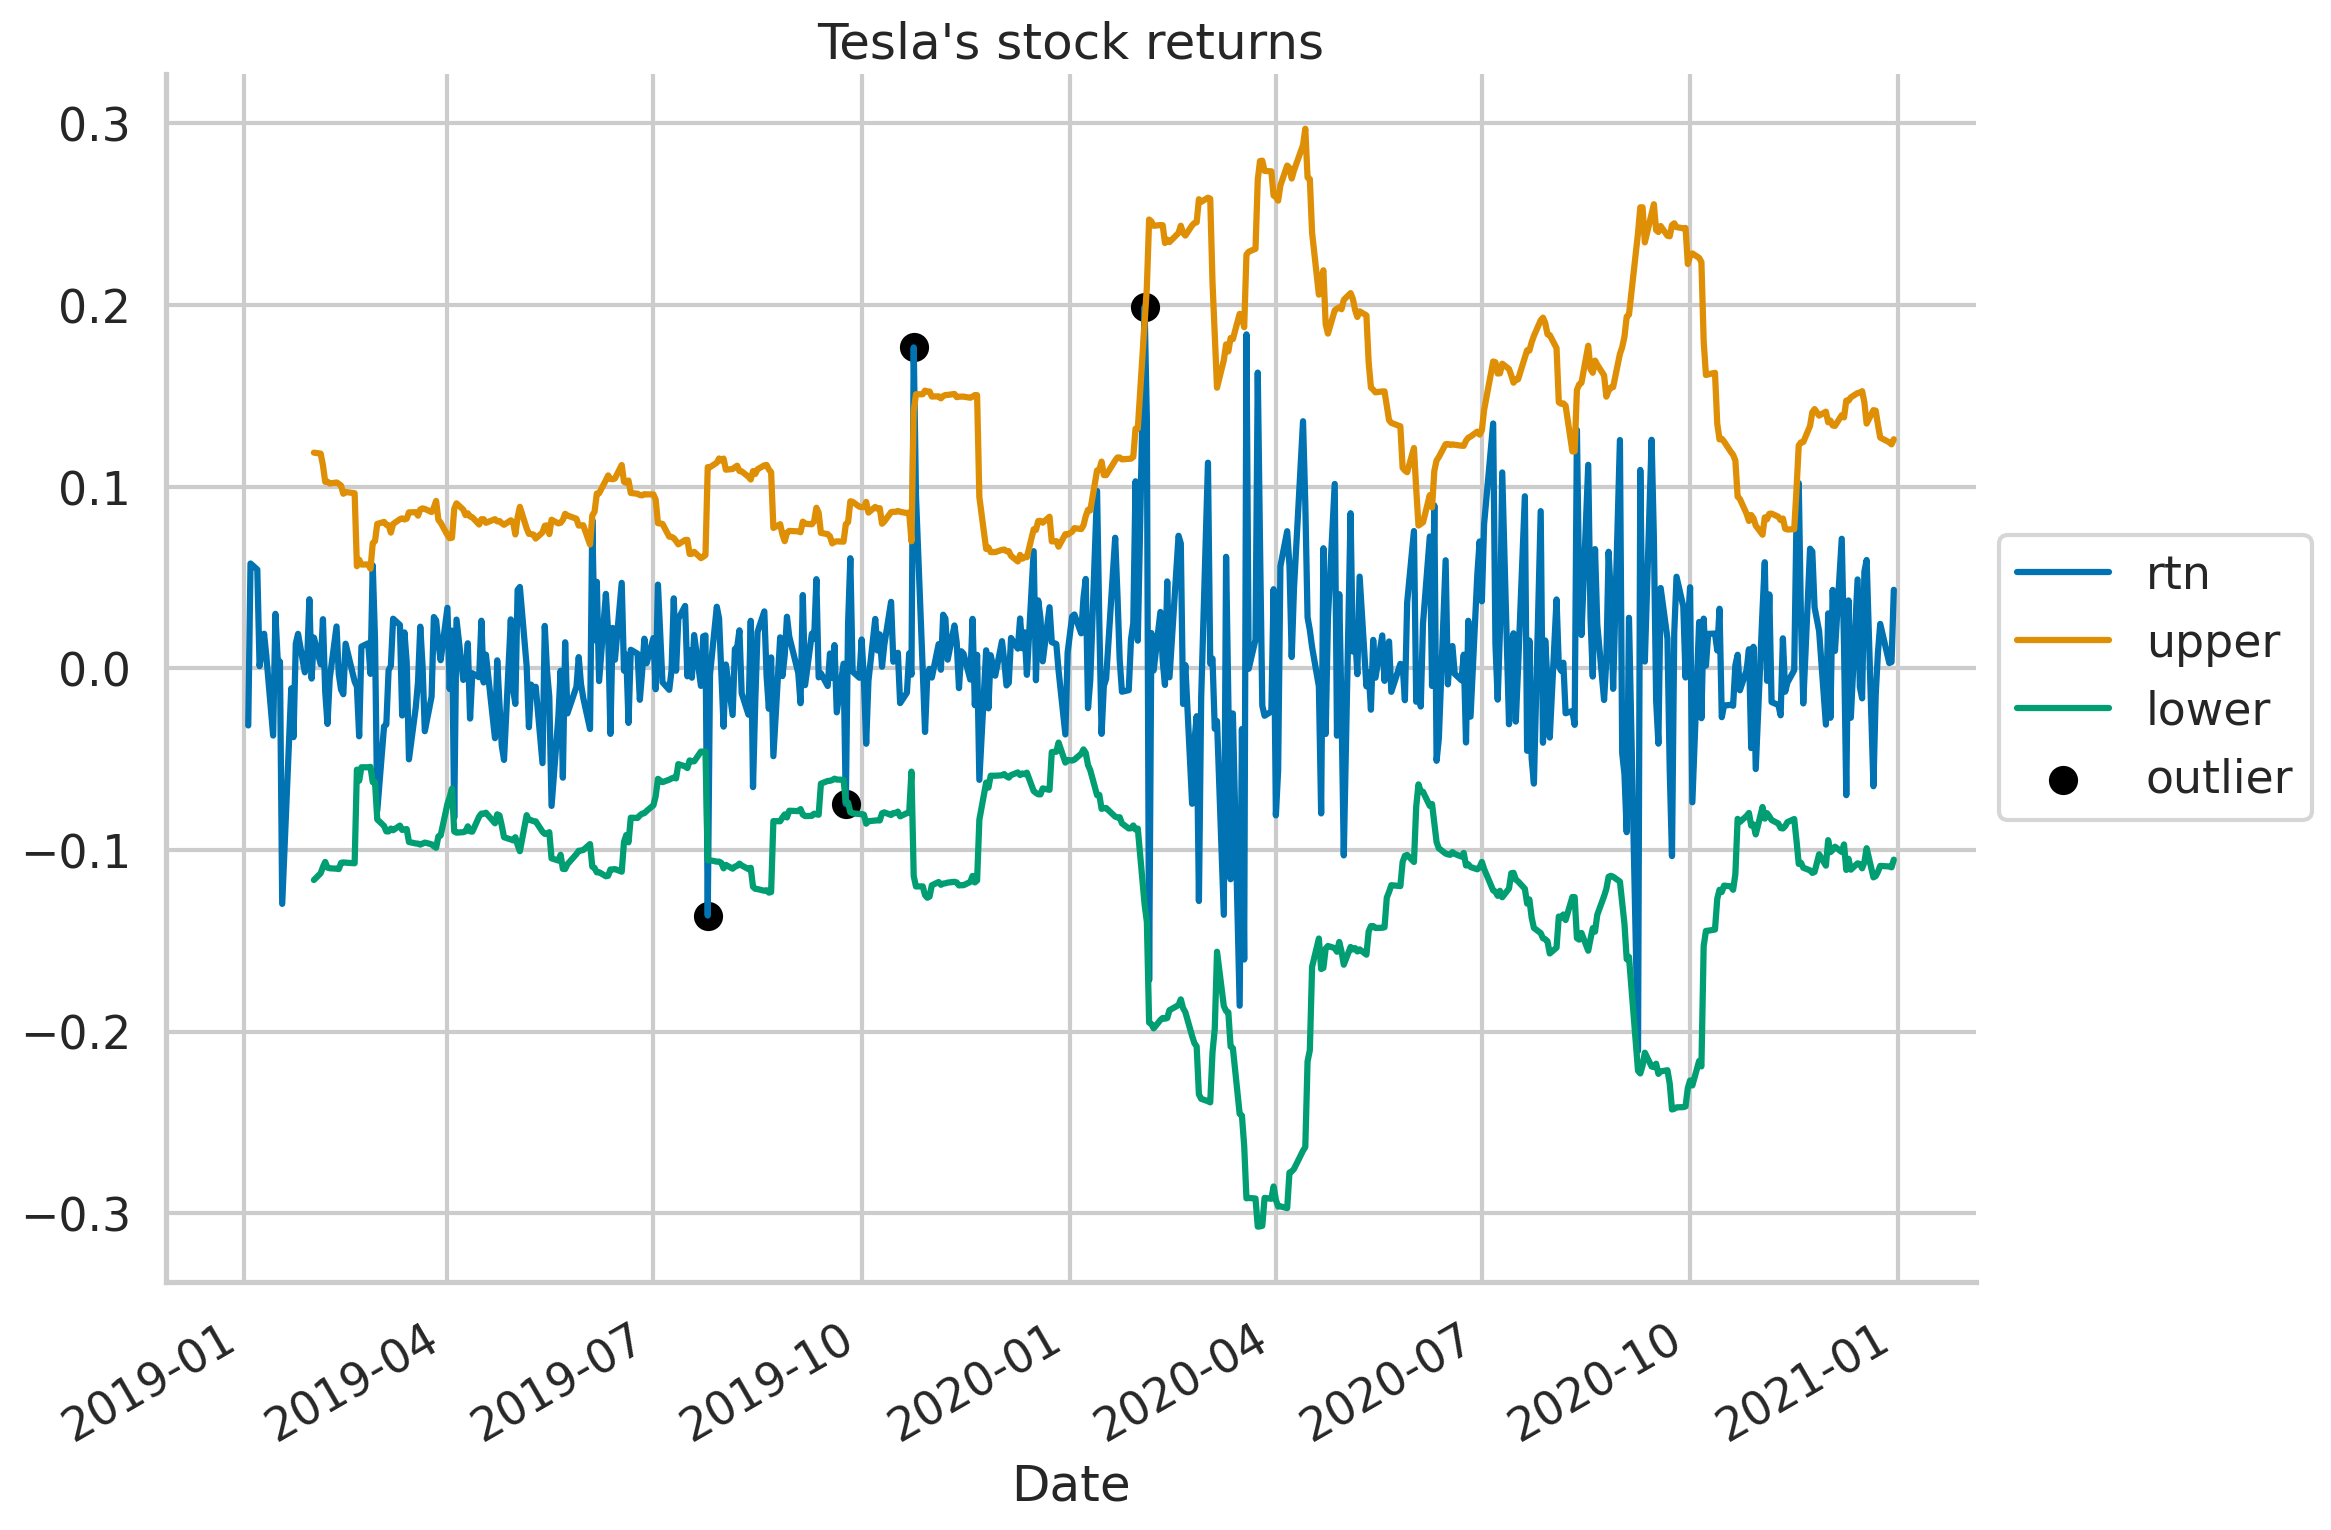

In [10]:
fig, ax = plt.subplots()

df[["rtn", "upper", "lower"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index, 
           df.loc[df["outlier"], "rtn"], 
           color="black", label="outlier")
ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_1", dpi=200)

그래프에서 검은 점으로 표시된 이상치와 함께 이를 결정하는 데 사용된 임계값을 관찰할 수 있습니다. 주목할 점은, 절대적인 측면에서 두 개의 큰 수익률이 서로 근접해 있을 때, 알고리즘은 첫 번째 수익률을 이상치로 식별하고 두 번째 수익률을 일반적인 관측치로 간주한다는 것입니다. 이는 첫 번째 이상치가 롤링 윈도우에 들어가면서 이동 평균/표준 편차에 영향을 미치기 때문일 수 있습니다. 이러한 상황은 2020년 1분기에 관찰할 수 있습니다. 또한, 이른바 유령 효과(ghost effect)에도 유의해야 합니다. 단일 이상치가 롤링 윈도우에 들어가면, 그것이 롤링 윈도우 내에 있는 동안 롤링 통계 값이 부풀려집니다.

첨부된 그래프에서는 Tesla의 주가 수익률과 함께 이상치를 나타내는 검은 점과 임계값을 확인할 수 있습니다. 이 그래프를 이해하기 쉽게 설명해드리겠습니다.

**그래프 설명:**

1. **파란색 선 (rtn)**: 이 선은 Tesla의 일일 주가 수익률을 나타냅니다. 시간이 지남에 따라 주가 수익률이 어떻게 변했는지 보여줍니다.

2. **주황색 선 (upper)**: 이 선은 롤링 평균에서 3 표준 편차 위로 설정된 상단 임계값입니다. 수익률이 이 선을 넘어서면 이상치로 간주될 가능성이 큽니다.

3. **초록색 선 (lower)**: 이 선은 롤링 평균에서 3 표준 편차 아래로 설정된 하단 임계값입니다. 수익률이 이 선 아래로 떨어지면 이상치로 간주될 가능성이 큽니다.

4. **검은 점 (outlier)**: 이 점들은 실제로 이상치로 식별된 관측값을 나타냅니다. 주가 수익률이 상단 임계값을 넘거나 하단 임계값 아래로 떨어졌을 때, 해당 관측값은 검은 점으로 표시됩니다.

**주목할 점:**

- **근접한 큰 수익률**: 그래프에서 보이는 것처럼, 주가 수익률이 크게 변화한 경우, 두 개의 큰 수익률이 서로 근접해 있을 때 첫 번째 수익률은 이상치로 식별되지만, 두 번째 수익률은 일반적인 관측치로 간주됩니다. 이는 첫 번째 이상치가 롤링 윈도우에 포함되면서 이동 평균과 표준 편차에 영향을 주기 때문입니다.

- **유령 효과 (Ghost Effect)**: 이상치가 롤링 윈도우에 들어가면, 그 이상치가 윈도우에 있는 동안 롤링 통계 값이 부풀려지는 효과가 발생할 수 있습니다. 이는 다음 관측값들이 이상치로 식별되지 않게 하는 요인이 될 수 있습니다.

이렇게 롤링 윈도우와 이동 평균을 사용한 이상치 탐지 방법은, 시간에 따른 수익률의 변화를 분석하고 예외적인 값들을 확인하는 데 유용합니다. 하지만, 일부 한계점도 존재하므로 실제 데이터를 분석할 때는 이러한 요소들을 고려해야 합니다.

### There's more

**Define a function**

Define a function for identify outliers using the steps described in the previous section.

이 레시피에서는 이상치를 식별하기 위해 필요한 모든 단계를 DataFrame에서 개별적인 작업으로 수행하는 방법을 보여주었습니다. 그러나 모든 단계를 하나의 함수로 캡슐화하고, 보다 일반적으로 다양한 사용 사례를 처리할 수 있도록 만드는 것도 가능합니다. 아래에 그 예시를 제공합니다:

함수는 각 관측값이 이상치인지 여부를 나타내는 불리언 플래그를 포함한 `pd.Series`를 반환합니다. 함수를 사용함으로써 얻을 수 있는 추가적인 이점은 윈도우 크기나 임계값을 생성하기 위해 사용되는 표준 편차의 수와 같은 다양한 매개변수를 쉽게 실험해 볼 수 있다는 것입니다.

In [11]:
def identify_outliers(df, column, window_size, n_sigmas):
    """롤링 통계를 사용하여 이상치를 식별하는 함수"""
    
    # 지정된 열만 복사하여 사용 (원본 DataFrame을 수정하지 않기 위해)
    df = df[[column]].copy()
    
    # 주어진 윈도우 크기를 사용하여 이동 평균과 표준 편차 계산
    df_rolling = df.rolling(window=window_size) \
                   .agg(["mean", "std"])
    
    # MultiIndex로 생성된 열 이름에서 상위 레벨 제거
    df_rolling.columns = df_rolling.columns.droplevel()
    
    # 원본 DataFrame에 이동 평균과 표준 편차 데이터를 추가
    df = df.join(df_rolling)
    
    # 상위 및 하위 임계값 계산 (이상치 판단 기준)
    df["upper"] = df["mean"] + n_sigmas * df["std"]
    df["lower"] = df["mean"] - n_sigmas * df["std"]
    
    # 이상치 여부를 나타내는 불리언 시리즈 반환
    # 관측값이 상위 임계값을 초과하거나 하위 임계값 미만이면 True 반환
    return ((df[column] > df["upper"]) | (df[column] < df["lower"]))

In [12]:
identify_outliers(df, "rtn", 21, 3)

Date
2019-01-02    False
2019-01-03    False
2019-01-04    False
2019-01-07    False
2019-01-08    False
              ...  
2020-12-23    False
2020-12-24    False
2020-12-28    False
2020-12-29    False
2020-12-30    False
Length: 504, dtype: bool

**윈저화(Winsorization)**

이상치를 처리하는 또 다른 인기 있는 방법은 윈저화입니다. 윈저화는 데이터에서 이상치를 대체하여 잠재적인 계산에 미치는 영향을 제한하는 방법에 기반합니다. 윈저화는 예제를 통해 이해하는 것이 더 쉽습니다. 예를 들어, 90% 윈저화는 상위 5%의 값을 95번째 퍼센타일 값으로 대체하는 것을 의미합니다. 마찬가지로, 하위 5%는 5번째 퍼센타일 값으로 대체됩니다. `scipy` 라이브러리에서 `winsorize` 함수를 사용하여 윈저화를 수행할 수 있습니다.

## 4.2 Outlier detection with the Hampel filter

우리는 시계열에서 이상치를 탐지하기 위해 사용하는 또 다른 알고리즘인 Hampel 필터에 대해 다룰 것입니다. 이 알고리즘의 목적은 주어진 시계열에서 이상치를 식별하고, 필요하다면 대체하는 것입니다.

Hampel 필터는 중심으로부터 양쪽으로 x개의 관측값을 포함하는 크기 2x의 슬라이딩 윈도우를 사용하여 전체 시리즈를 탐색합니다. 각 슬라이딩 윈도우에 대해, 알고리즘은 중앙값과 중앙값 절대 편차(표준 편차의 한 형태)를 계산합니다.

중앙값 절대 편차가 표준 편차의 일관된 추정량이 되려면, 분포에 따라 달라지는 상수 스케일링 계수 k를 곱해야 합니다. 가우시안 분포의 경우 이 계수는 약 1.4826입니다.

이전 알고리즘과 유사하게, Hampel 필터는 윈도우의 중앙값에서 일정한 표준 편차 수 이상으로 차이가 나는 관측값을 이상치로 간주합니다. 그런 다음, 이러한 이상치를 윈도우의 중앙값으로 대체할 수 있습니다.

알고리즘의 하이퍼파라미터 설정을 변경하여 실험할 수 있습니다. 예를 들어, 더 높은 표준 편차 임계값을 사용하면 필터가 더 관대해지고, 낮은 임계값을 사용하면 더 많은 데이터 포인트가 이상치로 분류됩니다.

이번 레시피에서는 Hampel 필터를 사용하여 2019년부터 2020년까지의 Tesla 주가 시계열에서 이상치로 간주될 수 있는 관측값이 있는지 확인할 것입니다.


**Hampel 필터**

Hampel 필터는 시계열 데이터에서 이상치(outlier)를 탐지하고 제거하는 데 사용되는 통계적 기법입니다. 이 필터의 작동 방식은 다음과 같습니다:

1. 각 데이터 포인트에 대해 주변 데이터 포인트들의 중앙값을 계산합니다.
2. 해당 데이터 포인트와 중앙값의 차이를 구합니다.
3. 이 차이가 특정 임계값을 초과하면 해당 포인트를 이상치로 간주합니다.
4. 이상치로 판단된 데이터는 중앙값으로 대체됩니다.

Hampel 필터와 정규 분포의 표준편차를 사용하는 방법 사이에는 몇 가지 중요한 차이점이 있습니다:

1. 중심 경향 측정:
   - Hampel: 중앙값 사용
   - 표준편차: 평균 사용

2. 이상치에 대한 민감도:
   - Hampel: 극단값에 덜 민감 (로버스트)
   - 표준편차: 극단값에 매우 민감

3. 분포 가정:
   - Hampel: 특정 분포를 가정하지 않음
   - 표준편차: 정규 분포를 가정

4. 이상치 판단 기준:
   - Hampel: 중앙값으로부터의 절대 편차 사용
   - 표준편차: 평균으로부터의 거리를 표준편차 단위로 측정

5. 계산 복잡성:
   - Hampel: 상대적으로 계산이 복잡
   - 표준편차: 계산이 간단

Hampel 필터는 비대칭적이거나 꼬리가 두꺼운 분포에서도 효과적이며, 극단적인 이상치의 영향을 덜 받습니다. 반면 표준편차 방법은 정규 분포를 따르는 데이터에 더 적합합니다.

### How to do it...

1. Import the libraries:

처음 두 단계는 매우 일반적입니다. 라이브러리를 임포트하고, 주가 데이터를 다운로드하며, 단순 수익률을 계산했습니다.

In [14]:
import yfinance as yf
from sktime.transformations.series.outlier_detection import HampelFilter

2. Download Tesla's stock prices from 2019-2020 and calculate simple returns:

In [15]:
df = yf.download("TSLA", 
                 start="2019-01-01", 
                 end="2020-12-31",
                 progress=False)
df["rtn"] = df["Adj Close"].pct_change()

3. Instantiate the `HampelFilter` class and use it for detecting the outliers:

3단계에서는 HampelFilter 클래스의 객체를 생성했습니다. 이 필터는 sktime 라이브러리에서 제공하는 구현을 사용했습니다. 이 라이브러리는 7장에서 다룰 시계열 예측에 기초한 머신러닝 접근법에서 더 자세히 탐구할 것입니다. 우리는 길이 10의 윈도우(앞뒤로 각각 5개의 관측값)를 사용하며, 필터가 해당 관측값이 이상치인지 여부를 불리언 플래그로 반환하도록 설정했습니다.

기본적으로 return_bool 설정은 이상치를 NaN으로 대체한 새로운 시리즈를 반환합니다. 이는 sktime의 작성자들이 이상치를 식별하고 제거한 후, 누락된 값을 채우기 위해 동반되는 Imputer 클래스를 사용하는 것을 권장하기 때문입니다. sktime은 scikit-learn에서 사용 가능한 방법들과 유사한 메서드를 사용하기 때문에, 먼저 변환기 객체를 데이터에 맞추고(fit), 그런 다음 그것을 변환(transform)하여 해당 관측값이 이상치인지 여부를 나타내는 플래그를 얻어야 합니다. 여기에서는 조정된 종가(adjusted close price)에 대해 fit_transform 메서드를 사용하여 이 두 단계를 한 번에 완료했습니다. scikit-learn의 fit/transform API 사용에 대한 자세한 내용은 13장, "Applied Machine Learning: Identifying Credit Default"를 참조하시기 바랍니다.

In [16]:
hampel_detector = HampelFilter(window_length=10, 
                               return_bool=True)
df["outlier"] = hampel_detector.fit_transform(df["Adj Close"])
df.head()

,Open,High,Low,Close,Adj Close,Volume,rtn,outlier
Date,,,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000,NaN,False
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000,-0.031472,False
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500,0.057697,False
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000,0.054361,False
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500,0.001164,False


4. Plot Tesla's stock price and mark the outliers:

마지막 단계에서는 주가를 선 그래프로 플롯하고, 이상치는 검은 점으로 표시했습니다.

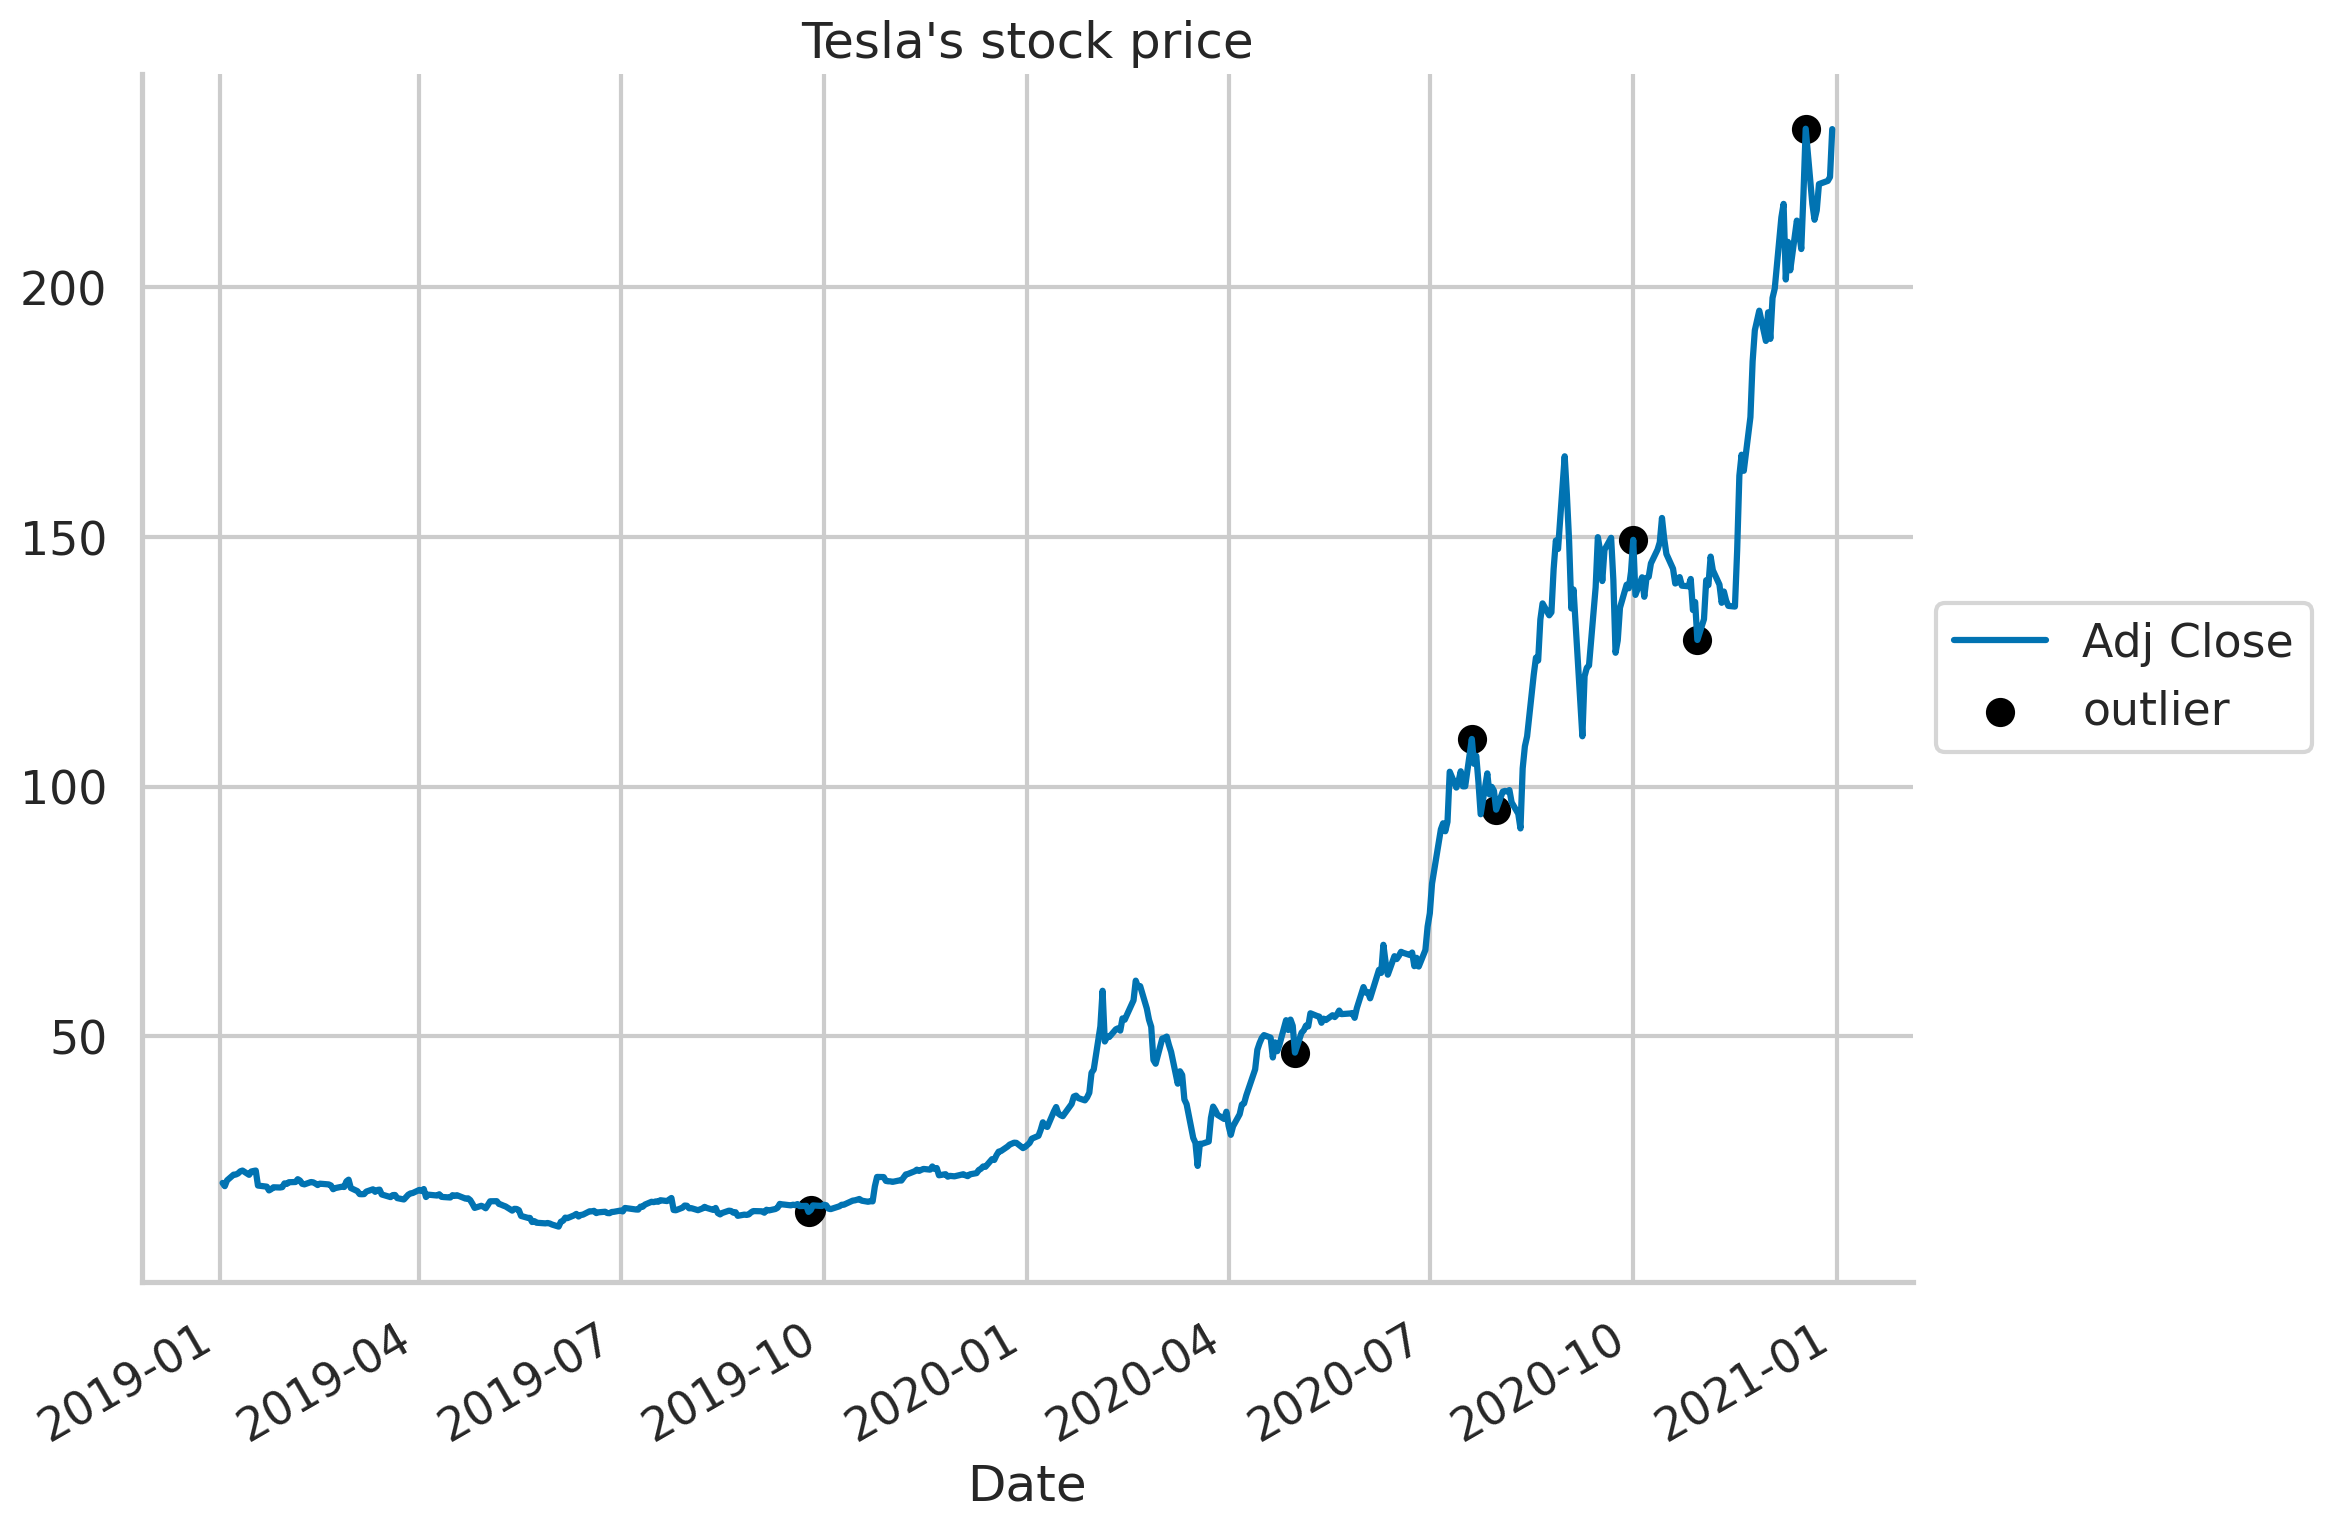

In [17]:
fig, ax = plt.subplots()

df[["Adj Close"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index, 
           df.loc[df["outlier"], "Adj Close"], 
           color="black", label="outlier")
ax.set_title("Tesla's stock price")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_2", dpi=200)

Hampel 필터를 사용하여 7개의 이상치를 식별했습니다. 처음 보았을 때, 2020년 9월경의 가장 큰 급등과 급락이 감지되지 않고, 이후의 더 작은 변동들이 감지된 것이 흥미롭고 약간 직관에 반하는 것처럼 보일 수 있습니다. 이 필터가 중심 윈도우를 사용하기 때문에, 급등의 정점에 있는 관측값을 분석할 때 알고리즘은 이전 및 이후의 5개의 관측값도 함께 고려합니다. 이 관측값들 역시 높은 값들을 포함하고 있기 때문에 이상치로 감지되지 않을 수 있습니다.

### There's more

비교를 위해, 동일한 필터를 조정된 종가를 사용하여 계산된 수익률에도 적용할 수 있습니다. 이렇게 하면 알고리즘이 다른 관측값을 이상치로 식별하는지 확인할 수 있습니다.

1. Identify the outliers among the stock returns:

In [18]:
df["outlier_rtn"] = hampel_detector.fit_transform(df["rtn"])
df.head()

/home/restful3/anaconda3/envs/trading38/lib/python3.8/site-packages/sktime/transformations/series/outlier_detection.py:103: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  Z = self._transform_series(Z)


,Open,High,Low,Close,Adj Close,Volume,rtn,outlier,outlier_rtn
Date,,,,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000,NaN,False,True
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000,-0.031472,False,False
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500,0.057697,False,False
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000,0.054361,False,False
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500,0.001164,False,False


2. Plot Tesla's daily returns and mark the outliers:

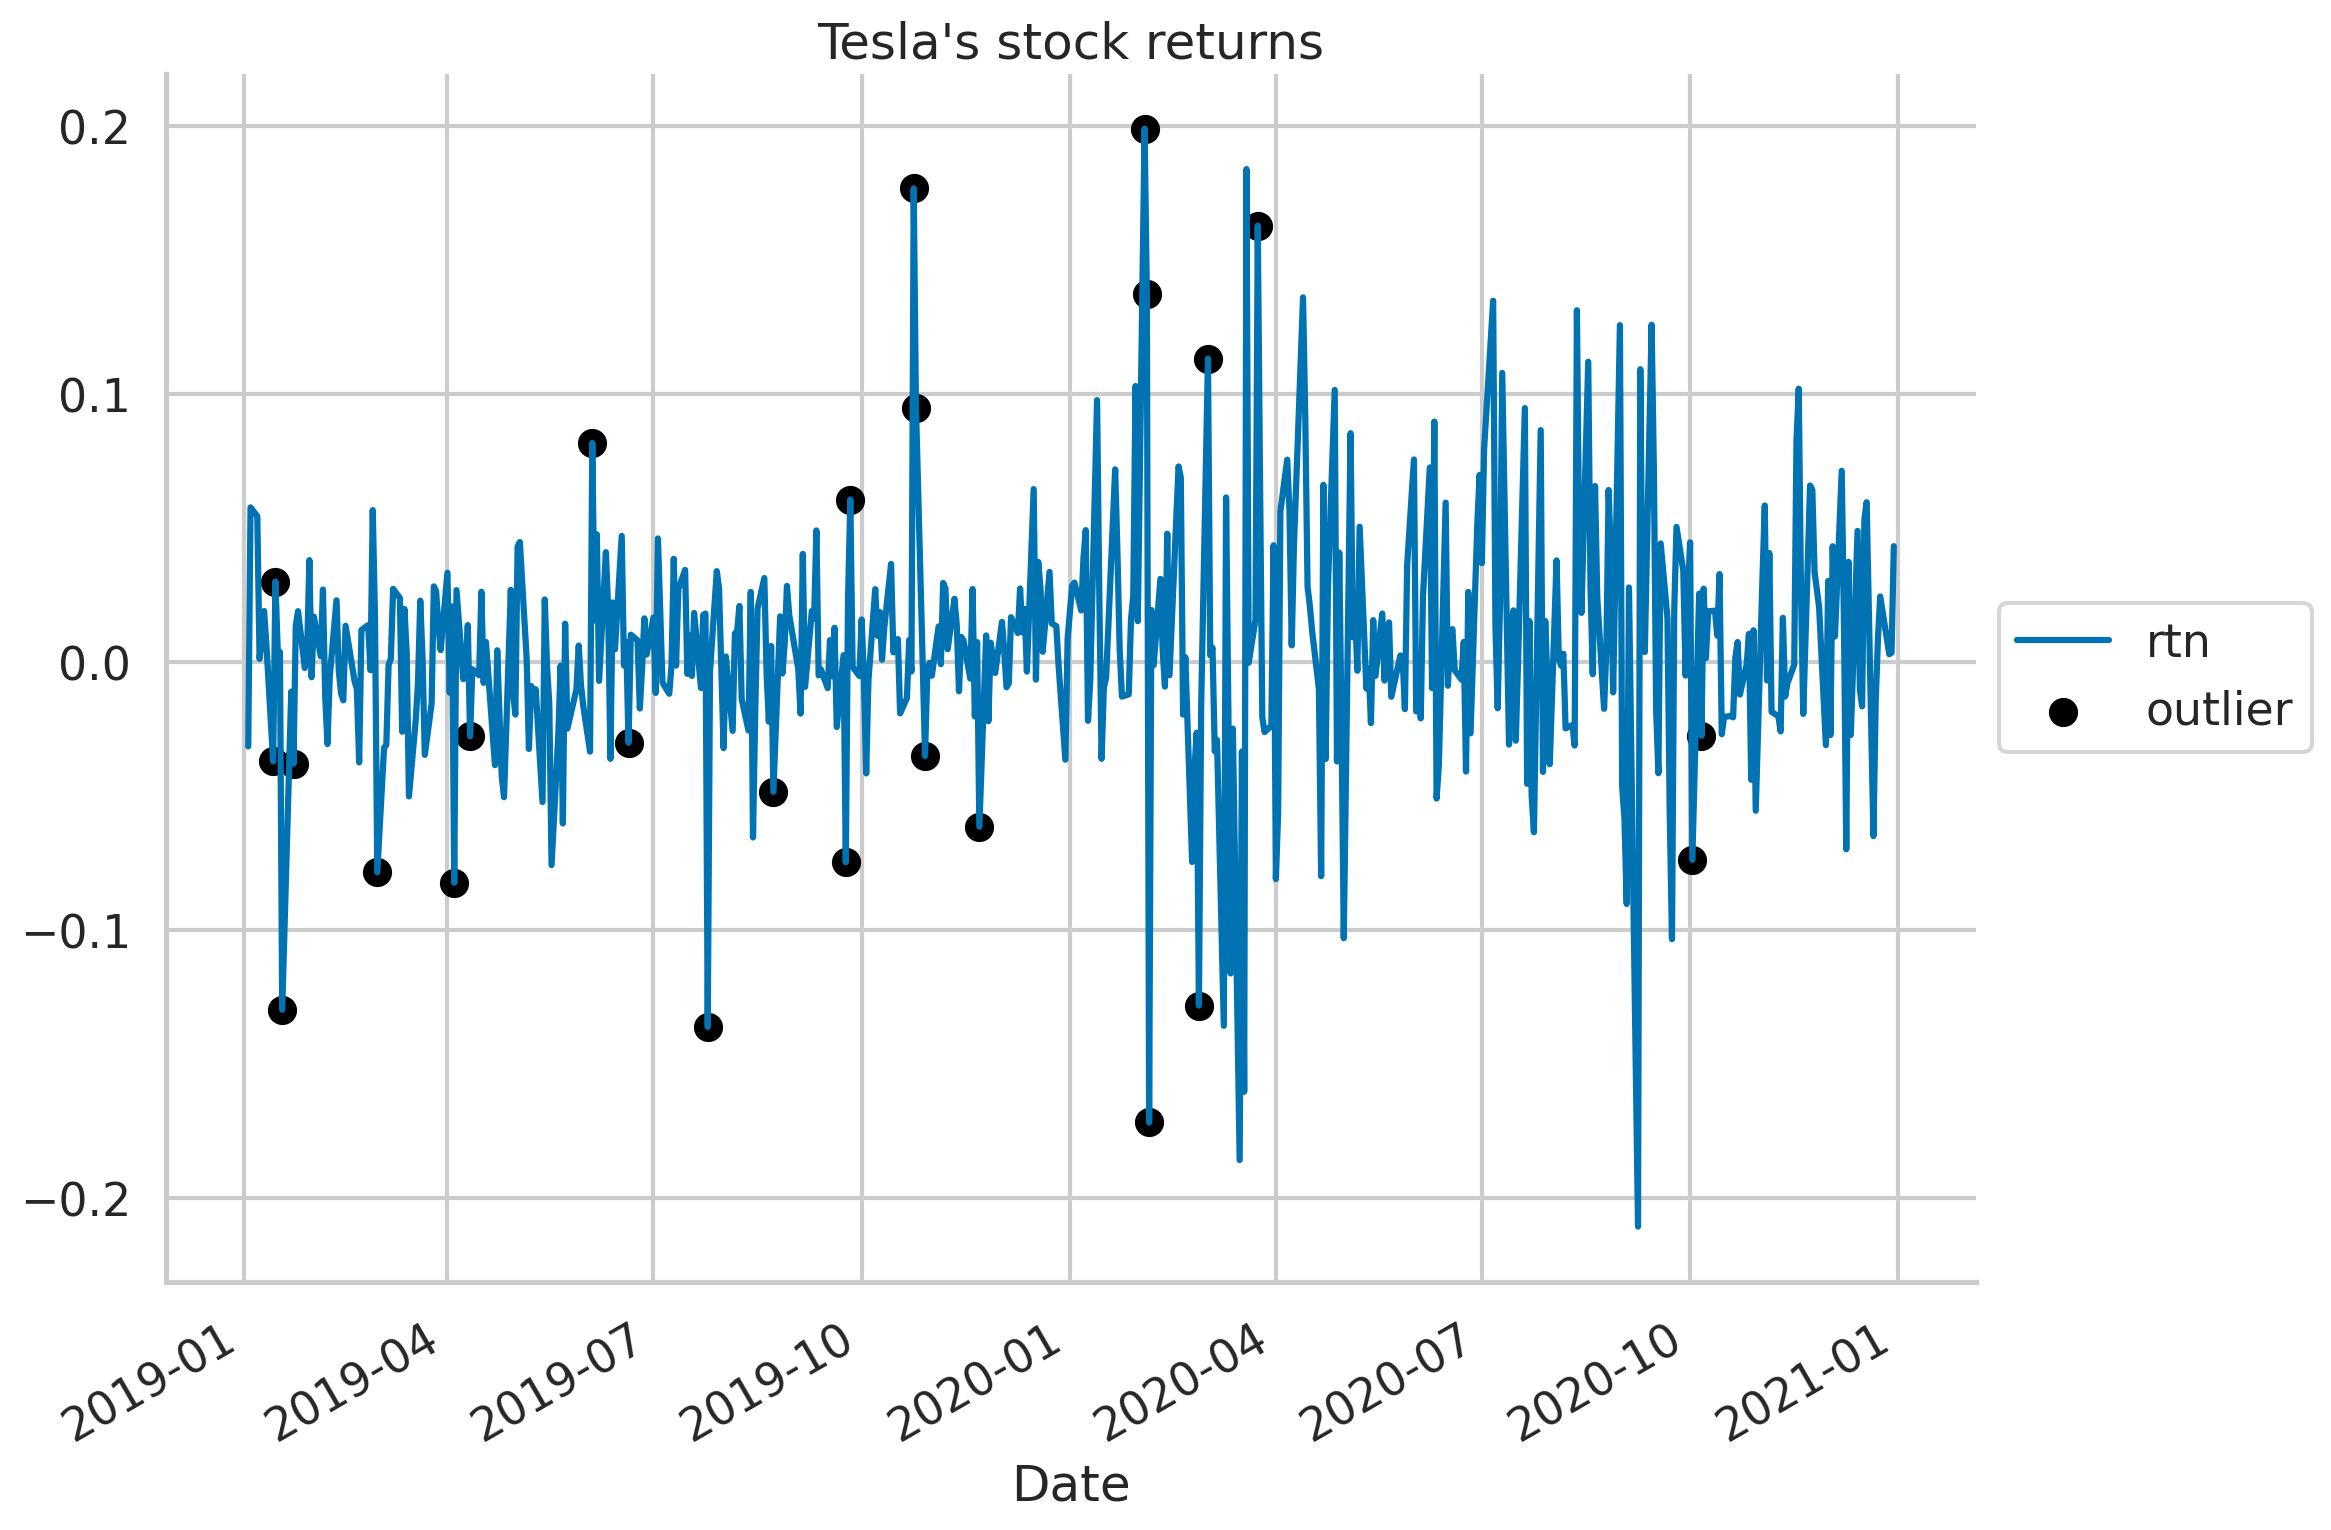

In [19]:
fig, ax = plt.subplots()

df[["rtn"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier_rtn"]].index, 
           df.loc[df["outlier_rtn"], "rtn"], 
           color="black", label="outlier")
ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_3", dpi=200)

3. Investigate the overlap in outliers identified for the prices and returns:

In [20]:
df.query("outlier == True and outlier_rtn == True").round(2)

,Open,High,Low,Close,Adj Close,Volume,rtn,outlier,outlier_rtn
Date,,,,,,,,,
2019-09-24,16.1,16.13,14.84,14.88,14.88,193372500,-0.07,True,True


**See also**

이상치/이상 탐지는 데이터 과학에서 매우 중요한 분야로, 의심스러운 관측값을 식별하는 여러 가지 접근 방식이 존재합니다. 우리는 특히 시계열 문제에 적합한 두 가지 알고리즘을 다루었습니다. 그러나 일반적으로 이상치 탐지에는 다양한 방법이 있습니다. 시계열 이외의 데이터를 대상으로 한 이상치 탐지 방법은 13장 "Applied Machine Learning: Identifying Credit Default"에서 다룰 예정입니다. 그 중 일부는 시계열에도 사용할 수 있습니다.

다음은 흥미로운 이상치/이상 탐지 라이브러리들입니다:
- [TODS](https://github.com/datamllab/tods)
- [Luminaire](https://github.com/zillow/luminaire/)
- [Orion](https://github.com/signals-dev/Orion)
- [PyCaret](https://pycaret.org/anomaly-detection/)
- [Luminol](https://github.com/linkedin/luminol) — LinkedIn에서 만든 라이브러리이지만, 현재는 더 이상 적극적으로 유지 관리되지 않습니다.
- [AnomalyDetection](https://github.com/twitter/AnomalyDetection) — Twitter에서 만든 이 R 패키지는 꽤 유명하며, 일부 개인 기여자들에 의해 Python으로 포팅되었습니다.

추가 참고자료:
- **Hampel F. R. 1974. “The influence curve and its role in robust estimation.” Journal of the American Statistical Association, 69: 382-393** — Hampel 필터를 소개한 논문
- [sktime 문서](https://www.sktime.org/en/latest/index.html) — sktime의 문서

## 4.3 Detecting changepoints in time series

변화점(changepoint)은 프로세스나 시계열의 확률 분포가 변하는 시점을 의미할 수 있습니다. 예를 들어, 시계열에서 평균이 변화하는 시점이 이에 해당합니다. 이 레시피에서는 CUSUM(누적 합) 방법을 사용하여 시계열에서 평균의 변화를 감지할 것입니다.

**이 레시피에서 사용하는 구현은 두 단계로 이루어집니다:**

1. **변화점 찾기**:
   - 주어진 시계열의 중간에 변화점을 초기화하여 반복적인 과정을 시작합니다.
   - 그런 다음, CUSUM 접근법을 선택한 지점을 기준으로 수행합니다.
   - 다음 변화점은 이전 CUSUM 시계열이 최대화되거나 최소화되는 지점(우리가 찾고자 하는 변화점의 방향에 따라)에서 찾습니다.
   - 이 과정을 안정적인 변화점이 발견되거나 최대 반복 횟수를 초과할 때까지 계속합니다.

2. **통계적 유의성 테스트**:
   - 로그 가능도 비율 검정을 사용하여, 시계열의 평균이 식별된 변화점에서 변경되었는지 테스트합니다. 
   - 귀무 가설은 시리즈의 평균에 변화가 없다는 것입니다.

**알고리즘 구현에 대한 몇 가지 추가 설명:**

- 이 알고리즘은 상승 및 하락 변화 모두를 감지할 수 있습니다.
- 이 알고리즘은 최대 하나의 상승 변화점과 하나의 하락 변화점을 찾을 수 있습니다.
- 기본적으로, 귀무 가설이 기각된 경우에만 변화점이 보고됩니다.
- 내부적으로, CUSUM 시계열 값을 계산하고 가설 검정을 수행하기 위해 가우시안 분포가 사용됩니다.

이 레시피에서는 CUSUM 알고리즘을 적용하여 2020년 애플 주가에서 변화점을 식별할 것입니다.

### How to do it...

1. Import the libraries:

첫 번째 단계에서는 필요한 라이브러리들을 임포트했습니다. 변곡점(Changepoint) 감지를 위해 Facebook의 kats 라이브러리를 사용했습니다.

In [23]:
import yfinance as yf
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData

2. Download Apple's stock price from 2020:

이후, 2020년부터 Apple의 주가 데이터를 가져왔으며,

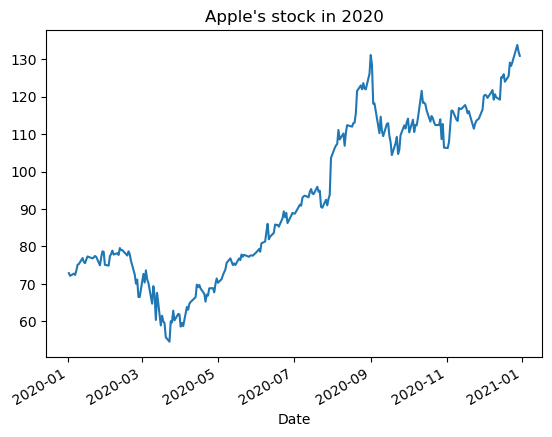

In [24]:
df = yf.download("AAPL", 
                 start="2020-01-01", 
                 end="2020-12-31", 
                 progress=False)
df["Adj Close"].plot(title="Apple's stock in 2020");

3. Keep only the adjusted close price, reset the index and rename the columns:

이 분석에서는 조정된 종가(Adjusted Close Prices)를 사용했습니다. `kats`를 사용하려면 데이터를 특정 형식으로 준비해야 합니다. 그래서 3단계에서 조정된 종가만 유지하고, 인덱스를 삭제하지 않고 초기화한 후(이 열이 필요하기 때문) 열의 이름을 변경했습니다. 여기서 중요한 점은 날짜/시간을 포함하는 열의 이름이 반드시 `time`이어야 한다는 것입니다. 

In [25]:
df = df[["Adj Close"]].reset_index(drop=False)
df.columns = ["time", "price"]

4. Convert the DataFrame into a `TimeSeriesData` object:

4단계에서는 DataFrame을 `kats`에서 사용하는 `TimeSeriesData` 객체로 변환했습니다. 

In [26]:
tsd = TimeSeriesData(df)

5. Instantiate and run the changepoint detector:

5단계에서는 이전에 생성한 데이터를 사용하여 `CUSUMDetector`를 인스턴스화했습니다. 기본 설정을 변경하지 않았습니다. 그런 다음 `detector` 메서드를 사용하여 변곡점을 식별했습니다. 이번 분석에서는 증가에만 관심이 있었기 때문에 `change_directions` 인수를 지정했습니다.

마지막으로 `cusum_detector` 객체의 `plot` 메서드를 사용하여 감지된 변곡점을 플롯했습니다. 여기서 주의할 점은 이 메서드에 식별된 변곡점을 입력으로 제공해야 한다는 것입니다.

<AxesSubplot:>

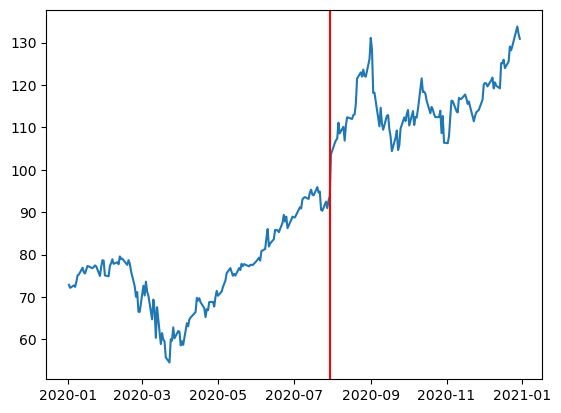

In [27]:
cusum_detector = CUSUMDetector(tsd)
change_points = cusum_detector.detector(
    change_directions=["increase"]
)
cusum_detector.plot(change_points)

6. Investigate the detected changepoint in more detail:

마지막 단계에서는 감지된 변곡점을 더 자세히 살펴보았습니다. 반환된 객체는 두 개의 요소를 포함하는 리스트로, 하나는 식별된 변곡점의 날짜와 알고리즘의 신뢰도와 같은 정보를 포함하는 `TimeSeriesChangePoint` 객체이고, 다른 하나는 메타데이터 객체입니다. 후자의 `__dict__` 메서드를 사용하면 변곡점의 방향, 변곡점 전후의 평균, 우도비 검정의 p-value 등 더 많은 정보를 확인할 수 있습니다.

In [28]:
change_points

[CUSUMChangePoint(start_time: 2020-07-30 00:00:00, end_time: 2020-07-30 00:00:00, confidence: 1.0, direction: increase, index: 145, delta: 39.514498112891246, regression_detected: True, stable_changepoint: True, mu0: 76.27388342765913, mu1: 115.78838154055038, llr: 451.8956919462488, llr_int: inf, p_value: 0.0, p_value_int: nan)]

In [29]:
# point, meta = change_points[0]
# point

In [30]:
# meta.__dict__

### There's more

이 라이브러리는 변곡점 감지와 관련하여 몇 가지 흥미로운 기능들을 더 제공합니다. 이 중 두 가지 기능만 다루겠지만, 여러분이 직접 더 탐구해 보시기를 권장합니다.

1. Narrow down the window in which we want to search for the changepoint:

Restricting the detection window

첫 번째 기능은 변곡점을 찾고자 하는 창(window)을 제한하는 것입니다. 이를 위해 detector 메서드의 interest_window 인수를 사용할 수 있습니다. 아래 예시에서는 200번째에서 250번째 관측치 사이에서만 변곡점을 찾았습니다. 참고로, 이 데이터는 거래일 기준의 연도이므로 전체 달력 연도가 아니며, 약 252개의 관측치가 있습니다. 이렇게 하면 변곡점을 찾고자 하는 창을 좁힐 수 있습니다.

<AxesSubplot:>

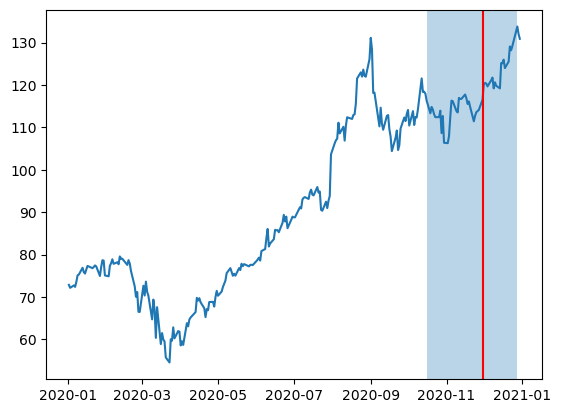

In [31]:
change_points = cusum_detector.detector(change_directions=["increase"], 
                                        interest_window=[200, 250])
cusum_detector.plot(change_points)

2. Use another algorithm to detect changepoints (`RobustStatDetector`): 


다양한 변곡점 감지 알고리즘 사용

`kats` 라이브러리에는 변곡점 감지를 위한 여러 흥미로운 알고리즘들이 포함되어 있습니다. 그 중 하나가 `RobustStatDetector`입니다. 알고리즘의 세부적인 설명은 생략하고, 이 알고리즘은 관심 지점을 식별하기 전에 이동 평균을 사용해 데이터를 평활화(smoothing)합니다. 이 알고리즘의 또 다른 흥미로운 특징은 한 번의 실행으로 여러 변곡점을 감지할 수 있다는 점입니다. 이제 `RobustStatDetector`를 사용하여 변곡점을 감지해 보겠습니다.

<AxesSubplot:>

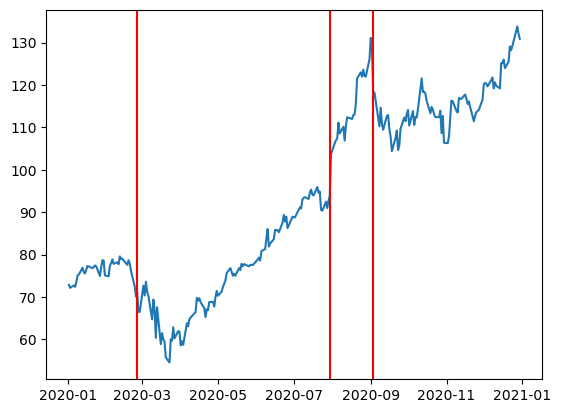

In [32]:
from kats.detectors.robust_stat_detection import RobustStatDetector

robust_detector = RobustStatDetector(tsd)
change_points = robust_detector.detector()
robust_detector.plot(change_points)

3. Change the `RobustStatDetector`'s default arguments:

<AxesSubplot:>

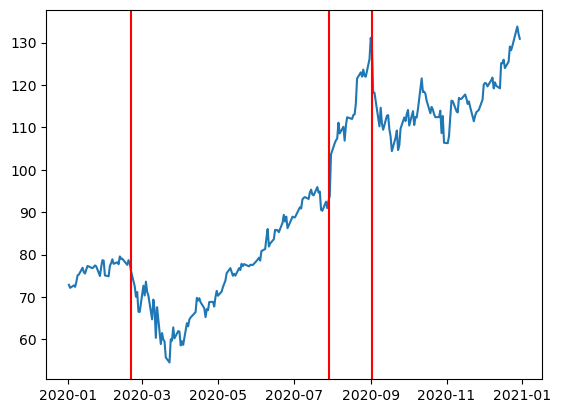

In [12]:
robust_detector = RobustStatDetector(tsd)
changepoints = robust_detector.detector(p_value_cutoff = 0.01, comparison_window=-5)
robust_detector.plot(changepoints)

이번에는 이전 시도와 비교했을 때 알고리즘이 두 개의 추가 변곡점을 감지했습니다. `kats` 라이브러리가 제공하는 또 다른 흥미로운 알고리즘은 **Bayesian Online Change Point Detection (BOCPD)**입니다. 이에 대한 참고 문헌은 "See also" 섹션에서 제공합니다.

**See also**

- [Facebook의 Kats GitHub 리포지토리](https://github.com/facebookresearch/Kats)
- Page, E. S. 1954. "Continuous inspection schemes." Biometrika 41(1): 100–115.
- Adams, R. P., & MacKay, D. J. (2007). "Bayesian online changepoint detection." arXiv preprint arXiv:0710.3742.

## 4.4 Detecting trends in time series

이전 레시피에서 변곡점 감지에 대해 다뤘습니다. 시간 시계열에서 중요한 장기 변화를 식별하는 추세 감지를 위한 또 다른 알고리즘 클래스가 있습니다. `kats` 라이브러리는 비모수적 Mann-Kendall (MK) 테스트를 기반으로 한 추세 감지 알고리즘을 제공합니다. 이 알고리즘은 지정된 크기의 윈도우에서 반복적으로 MK 테스트를 수행하고, 이 테스트가 통계적으로 유의미한 결과를 나타낸 각 윈도우의 시작점을 반환합니다. 윈도우 내에 유의미한 추세가 있는지 감지하기 위해, 이 테스트는 값의 변화 크기보다는 시간 시계열의 증가/감소의 단조성을 검사합니다.

MK 테스트는 Kendall의 Tau라는 통계치를 사용하며, 이는 -1에서 1까지의 범위를 가집니다. 이 값을 다음과 같이 해석할 수 있습니다:
- -1: 완전히 단조로운 감소를 나타냅니다.
- 1: 완전히 단조로운 증가를 나타냅니다.
- 0: 시계열에 방향성 추세가 없음을 나타냅니다.

기본적으로, 이 알고리즘은 통계적으로 유의미한 결과를 보인 기간만을 반환합니다. 그래프에서 추세를 쉽게 확인할 수 있는데 왜 이런 알고리즘을 사용할 필요가 있을까요? 이는 매우 타당한 질문입니다. 그러나 이러한 알고리즘을 사용하는 목적은 한 번에 하나의 시계열과 기간 이상을 분석하는 것입니다. 우리는 예를 들어 수백 개의 시계열에서 상승 추세를 찾는 것처럼, 대규모로 추세를 감지할 수 있어야 합니다.

이 레시피에서는 추세 감지 알고리즘을 사용하여 2020년부터 NVIDIA의 주가에서 유의미한 상승 추세가 있었는지 조사해 보겠습니다.

### How to do it...

1. Import the libraries:

In [33]:
import yfinance as yf
from kats.consts import TimeSeriesData
from kats.detectors.trend_mk import MKDetector

2. Download NVIDIA's stock prices from 2020:

처음 네 단계는 이전 레시피와 매우 유사하며, 이번에는 2020년부터 NVIDIA의 주가를 다운로드한 것만 다릅니다. `kats` 라이브러리를 사용하기 위한 데이터 준비에 대한 자세한 내용은 이전 레시피를 참조하세요.

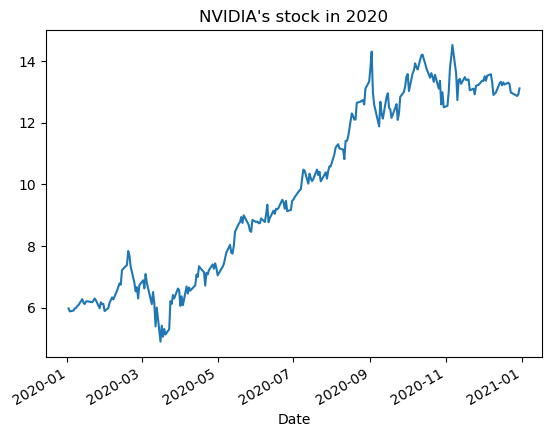

In [34]:
df = yf.download("NVDA", 
                 start="2020-01-01", 
                 end="2020-12-31", 
                 progress=False)
df["Adj Close"].plot(title="NVIDIA's stock in 2020");

3. Keep only the adjusted close price, reset the index and rename the columns:

In [35]:
df = df[["Adj Close"]].reset_index(drop=False)
df.columns = ["time", "price"]

4. Convert the DataFrame into a `TimeSeriesData` object:

In [36]:
tsd = TimeSeriesData(df)

5. Instantiate and run the trend detector:

5단계에서는 `MKDetector` 클래스를 사용하여 추세 감지기를 인스턴스화했으며, 데이터를 제공하면서 Tau 계수의 임계값을 0.9로 변경했습니다. 이렇게 하면 더 강한 추세를 나타내는 기간만을 얻을 수 있습니다. 그런 다음 `detector` 메서드를 사용하여 시간 지점을 찾았습니다. 우리는 30일 윈도우에서의 상승 추세(`direction="up"`)에 관심이 있었습니다. 

또한 `detector`의 다른 매개변수도 조정할 수 있습니다. 예를 들어, `freq` 인수를 사용하여 데이터에 계절성이 있는지 지정할 수 있습니다.

In [37]:
trend_detector = MKDetector(tsd, threshold=0.9)
time_points = trend_detector.detector(
    direction="up", 
    window_size=30
)

/home/restful3/anaconda3/envs/trading38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/restful3/anaconda3/envs/trading38/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


6. Plot the detected time points:

6단계에서는 결과를 플롯했습니다. 또한 감지된 95개의 각 지점을 자세히 조사할 수도 있습니다. 반환된 `time_points` 객체는 튜플 목록으로, 각 튜플은 감지된 추세 기간의 시작 날짜를 포함하는 `TimeSeriesChangePoint` 객체와 해당 지점의 메타데이터를 포함합니다. 우리의 경우 30일 윈도우 동안의 상승 추세 기간을 찾았기 때문에, 추세가 증가하는 기간에 많은 겹침이 있을 것입니다. 플롯에서 볼 수 있듯이, 식별된 많은 지점들이 연속적입니다.

<AxesSubplot:>

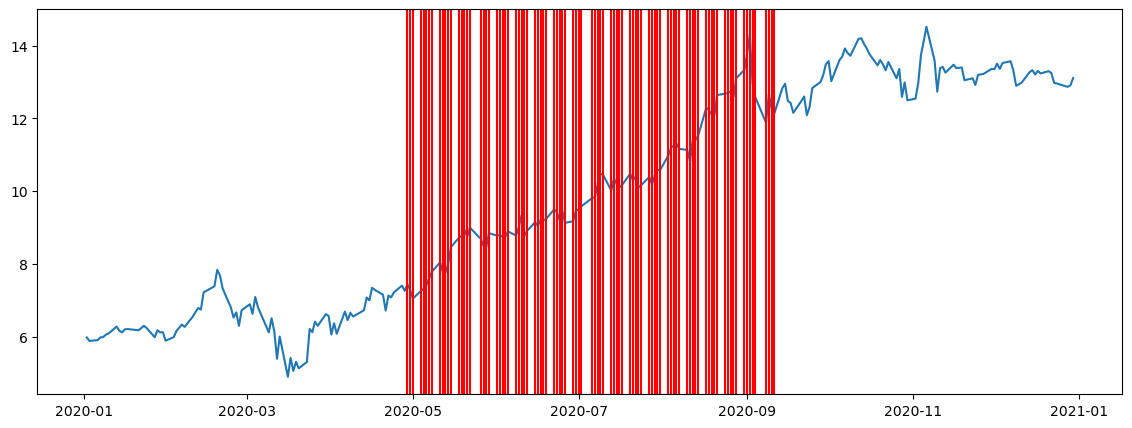

In [38]:
trend_detector.plot(time_points)

그림 4.8에서 볼 수 있듯이, 중간중간 간격이 있는 여러 기간이 나타납니다. 중요한 점은 빨간색 세로 막대가 감지된 윈도우가 아니라, 서로 인접한 위치에 있는 많은 감지된 추세 시작점을 나타낸다는 것입니다. 선택한 알고리즘 설정을 데이터에 적용한 결과, 95개의 상승 추세 기간이 식별되었으며, 이들 사이에 많은 겹침이 있다는 것이 분명합니다.

7. Investigate the detected points in more detail:

In [39]:
len(time_points)

95

Inspect a single time point:

In [40]:
time_points[0]

MKChangePoint(start_time: 2020-04-29 00:00:00, end_time: 2020-04-29 00:00:00, confidence: 0.999999999998759, detector_type: <class 'kats.detectors.trend_mk.MKDetector'>, is_multivariate: False, trend_direction: increasing Tau: 0.9172413793103448)

In [41]:
# cp, meta = time_points[0]

In [42]:
# cp

In [43]:
# meta.__dict__

## 4.5 Detecting patterns in a time series using the Hurst exponent

금융 분야에서는 많은 거래 전략이 다음 중 하나에 기반을 둡니다:

- **모멘텀(Momentum)**: 투자자들은 기존 시장 추세의 지속성을 이용하여 자신의 포지션을 결정하려고 합니다.
- **평균 회귀(Mean-reversion)**: 투자자들은 주식 수익률과 변동성 같은 속성이 시간이 지남에 따라 장기 평균으로 회귀할 것이라고 가정합니다(Ornstein-Uhlenbeck 과정이라고도 불립니다).

시계열 데이터를 시각적으로 검사하여 이를 두 가지 중 하나로 분류하는 것은 비교적 쉬울 수 있지만, 이 방법은 확장성에 한계가 있습니다. 그래서 우리는 Hurst 지수와 같은 접근 방식을 사용할 수 있습니다. Hurst 지수는 특정 시계열(반드시 금융 데이터일 필요는 없음)이 추세를 보이는지, 평균 회귀성을 가지는지, 아니면 단순한 랜덤 워크인지 식별하는 데 사용됩니다.

**랜덤 워크(Random Walk)** 란 경로가 무작위로 선택된 연속적인 단계로 구성되는 과정을 말합니다. 주가에 적용하면, 주가 변화는 동일한 분포를 가지며 서로 독립적이라는 것을 의미합니다. 이는 주가의 과거 움직임(또는 추세)이 미래 움직임을 예측하는 데 사용할 수 없다는 것을 암시합니다. 자세한 내용은 Chapter 10, Monte Carlo Simulations in Finance를 참조하세요.

**Hurst 지수(H)** 는 시계열의 장기 메모리(long-term memory)를 측정하는 지표로, 해당 시계열이 랜덤 워크에서 얼마나 벗어나는지를 측정합니다. Hurst 지수의 값은 0과 1 사이에 있으며, 다음과 같이 해석할 수 있습니다:

- **H < 0.5**: 시계열이 평균 회귀성을 나타냅니다. 값이 0에 가까울수록 평균 회귀 과정이 강해집니다.
- **H = 0.5**: 시계열이 기하학적 랜덤 워크를 나타냅니다.
- **H > 0.5**: 시계열이 추세를 나타냅니다. 값이 1에 가까울수록 추세가 강해집니다.

Hurst 지수를 계산하는 방법은 여러 가지가 있습니다. 이 레시피에서는 로그 가격의 분산을 기반으로 확산 행동의 속도를 추정하는 방법에 초점을 맞출 것입니다. 실용적인 예제로는 20년간의 일별 S&P 500 가격 데이터를 사용할 것입니다.

### How to do it...

1. Import the libraries:

필요한 라이브러리를 임포트한 후, 

In [79]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Download S&P 500's historical prices from the years 2000-2019:

Yahoo Finance에서 20년간의 일별 S&P 가격 데이터를 다운로드했습니다. 플롯을 살펴보면, 시계열이 순전히 추세를 보이는지, 평균 회귀성을 가지는지, 또는 랜덤 워크인지를 판단하기 어렵습니다. 특히 시계열의 후반부에서는 명확한 상승 추세가 보이는 것 같습니다.

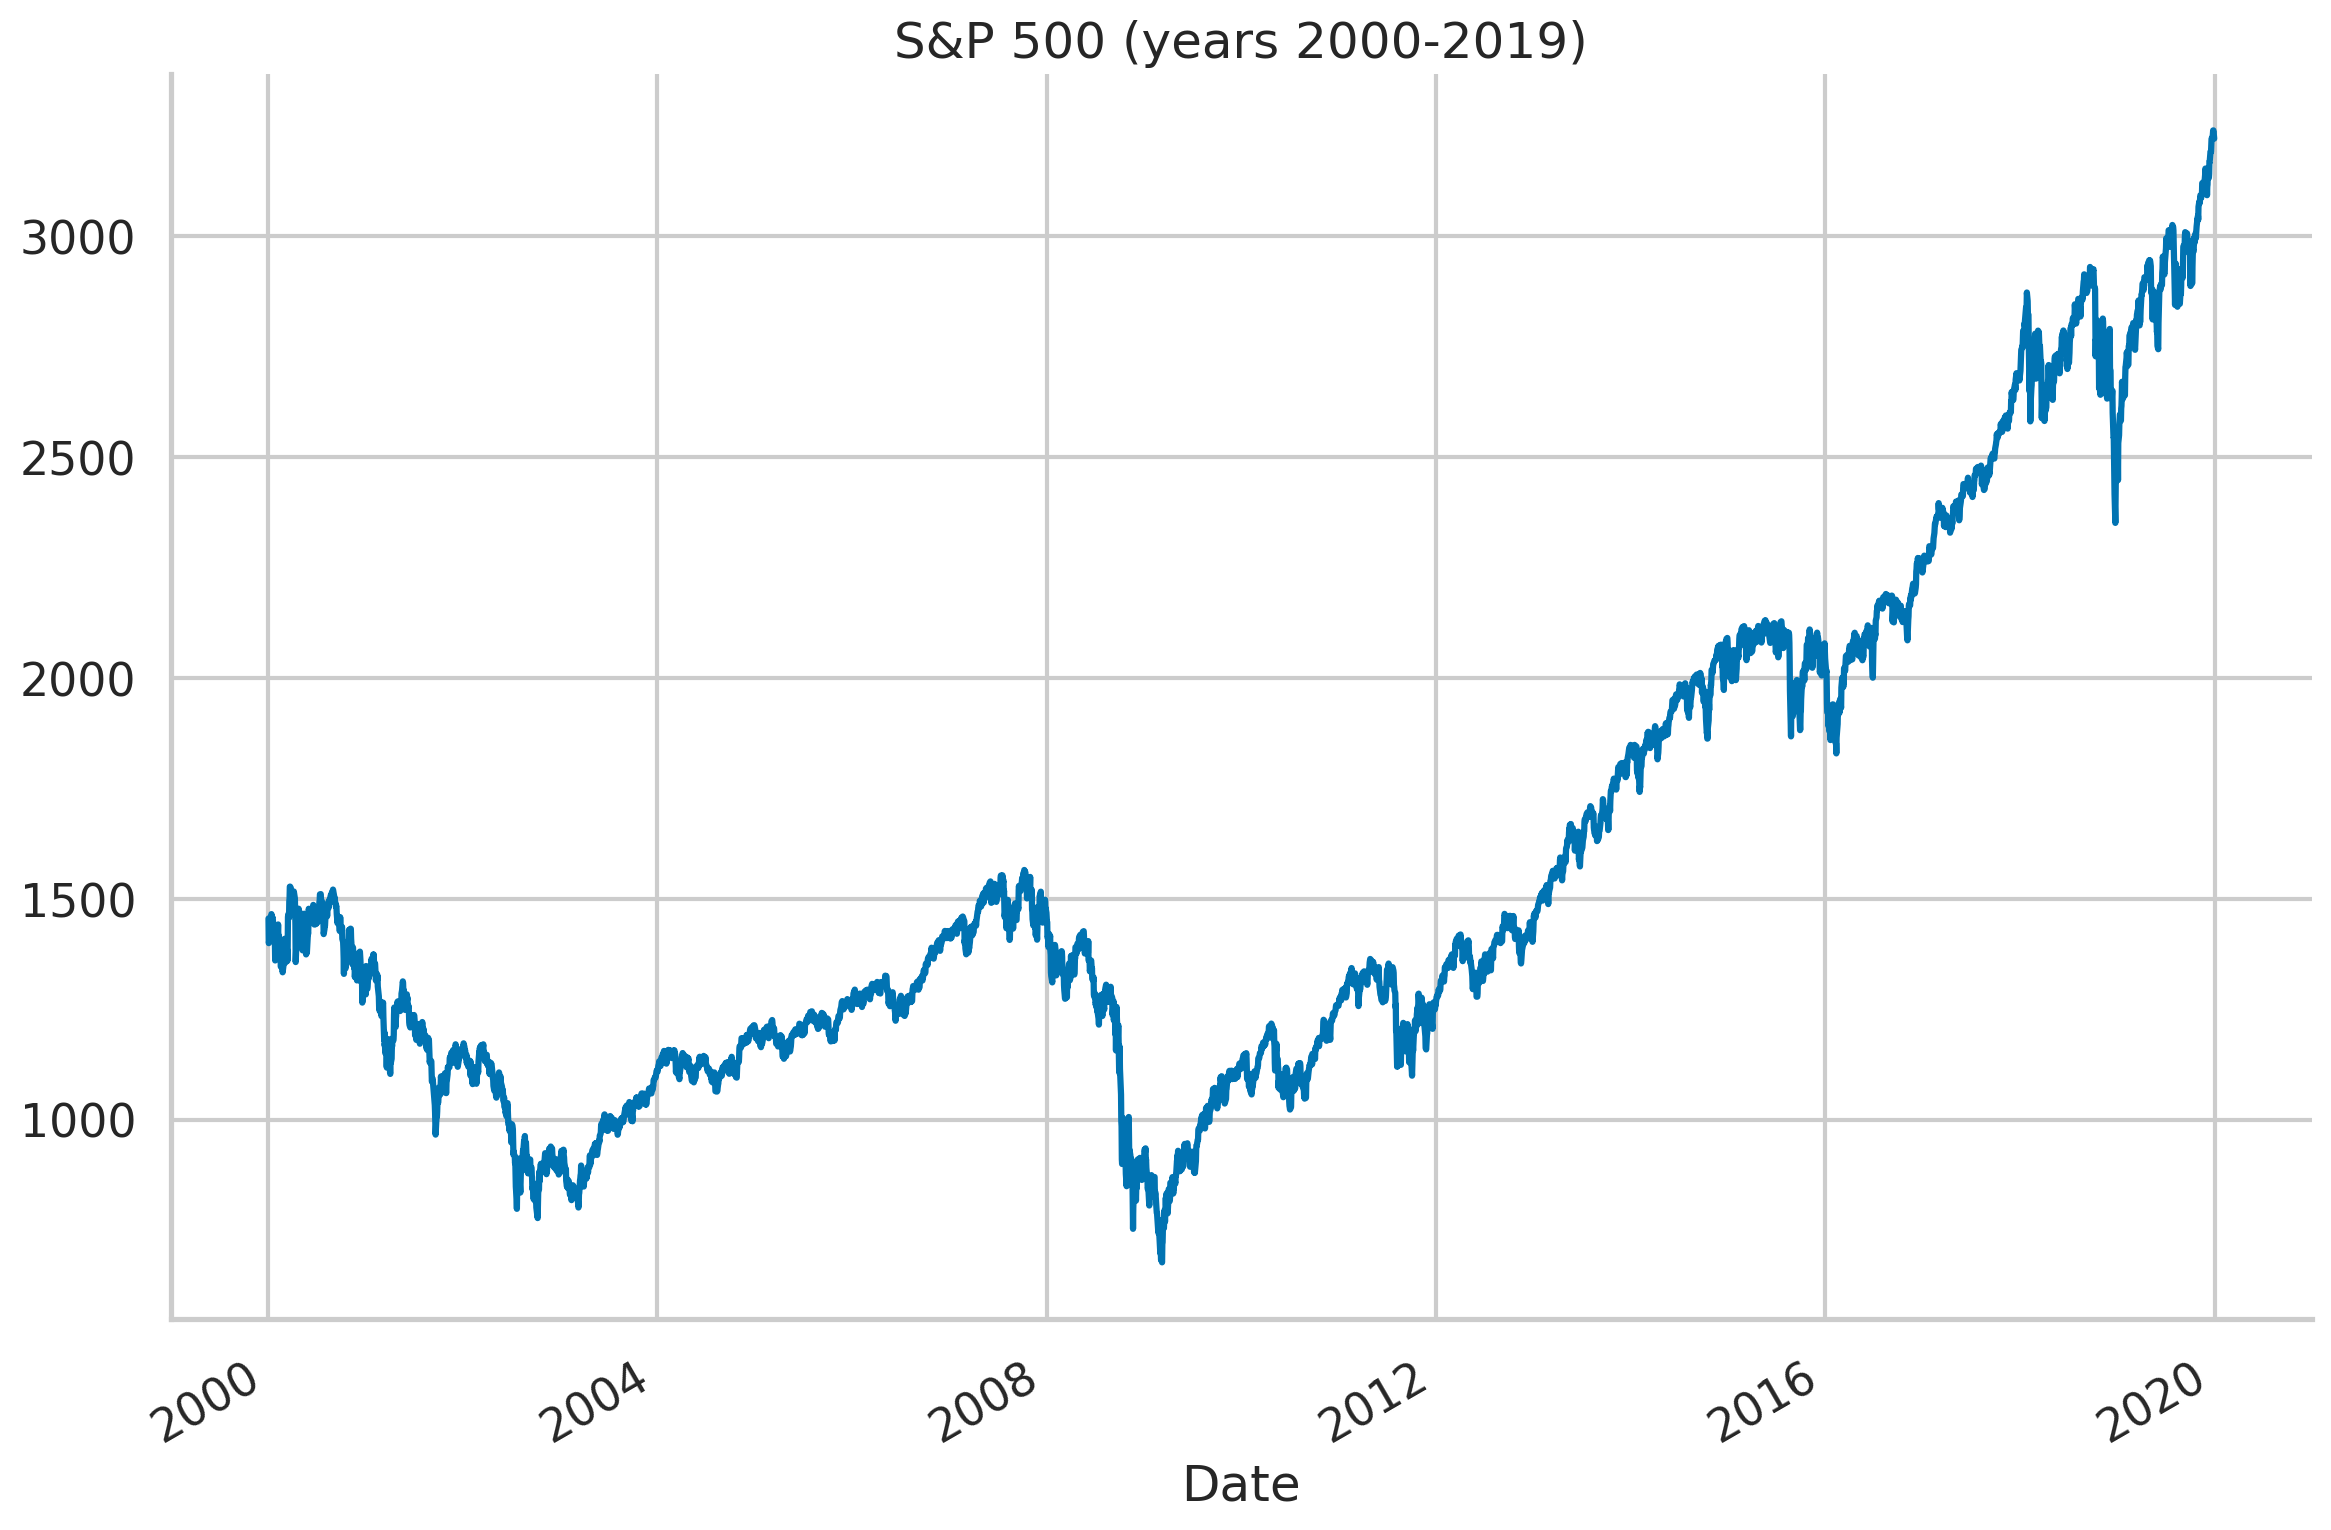

In [80]:
df = yf.download("^GSPC", 
                 start="2000-01-01", 
                 end="2019-12-31", 
                 progress=False)
df["Adj Close"].plot(title="S&P 500 (years 2000-2019)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_9", dpi=200);

3. Define a function calculating the Hurst exponent:

3단계에서는 Hurst 지수를 계산하기 위한 함수를 정의했습니다. 이 접근법에서는 계산에 사용할 최대 지연(lag) 수를 제공해야 합니다. 이 파라미터는 결과에 큰 영향을 미치며, 이는 이후에 확인할 수 있습니다. Hurst 지수의 계산은 두 단계로 요약할 수 있습니다:

1. 고려된 범위 내의 각 지연(lag)에 대해 차분 시계열의 표준 편차를 계산합니다(차분에 대한 자세한 내용은 6장, 시계열 분석 및 예측에서 다룰 예정입니다).
2. 지연(lag) 대 표준 편차의 로그 플롯의 기울기를 계산하여 Hurst 지수를 구합니다.

**Hurst 지수 계산 방법**

1. **지연(Lag) 설정**: 
   - 먼저, 시계열 데이터의 지연(lag) 값을 설정합니다. 이 코드에서는 `max_lag` 값을 20으로 설정했으므로, 2부터 19까지의 지연 값을 사용합니다.
   
2. **차분 시계열의 표준 편차 계산**:
   - 각 지연 값에 대해 시계열 데이터의 차분을 구한 다음, 그 차분의 표준 편차를 계산합니다. 이 과정은 시계열 데이터의 변화량을 측정하기 위한 것입니다.
   - 예를 들어, 지연 값이 2일 때, 원래 시계열에서 2만큼 시프트된 데이터와의 차이를 계산한 후, 그 차이의 표준 편차를 구합니다.

3. **로그 플롯의 기울기 계산**:
   - 지연 값과 표준 편차를 로그 변환한 후, 이 두 값을 플롯하여 기울기를 계산합니다. 이 기울기가 바로 Hurst 지수입니다.

In [81]:
def get_hurst_exponent(ts, max_lag=20):
    """시계열의 Hurst 지수를 반환합니다"""
    
    lags = range(2, max_lag)

    # 지연된 차분의 표준 편차 계산
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # 로그 플롯의 기울기를 계산하여 Hurst 지수를 구함
    hurst_exp = np.polyfit(np.log(lags), np.log(tau), 1)[0]

    return hurst_exp

4. Calculate the values of the Hurst exponent using different values for the `max_lag` parameter:

4단계에서는 `max_lag` 파라미터의 다양한 값에 대해 Hurst 지수를 계산하고 출력했습니다. 파라미터의 값이 낮을 때는 시계열이 약간의 평균 회귀성을 가진 것으로 간주될 수 있었습니다. 그러나 파라미터 값을 증가시킬수록, 해석이 시계열이 랜덤 워크에 가깝다는 쪽으로 바뀌었습니다.

In [82]:
for lag in [20, 100, 250, 500, 1000]:
    hurst_exp = get_hurst_exponent(df["Adj Close"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.4481
Hurst exponent with 100 lags: 0.4513
Hurst exponent with 250 lags: 0.4918
Hurst exponent with 500 lags: 0.5265
Hurst exponent with 1000 lags: 0.5178


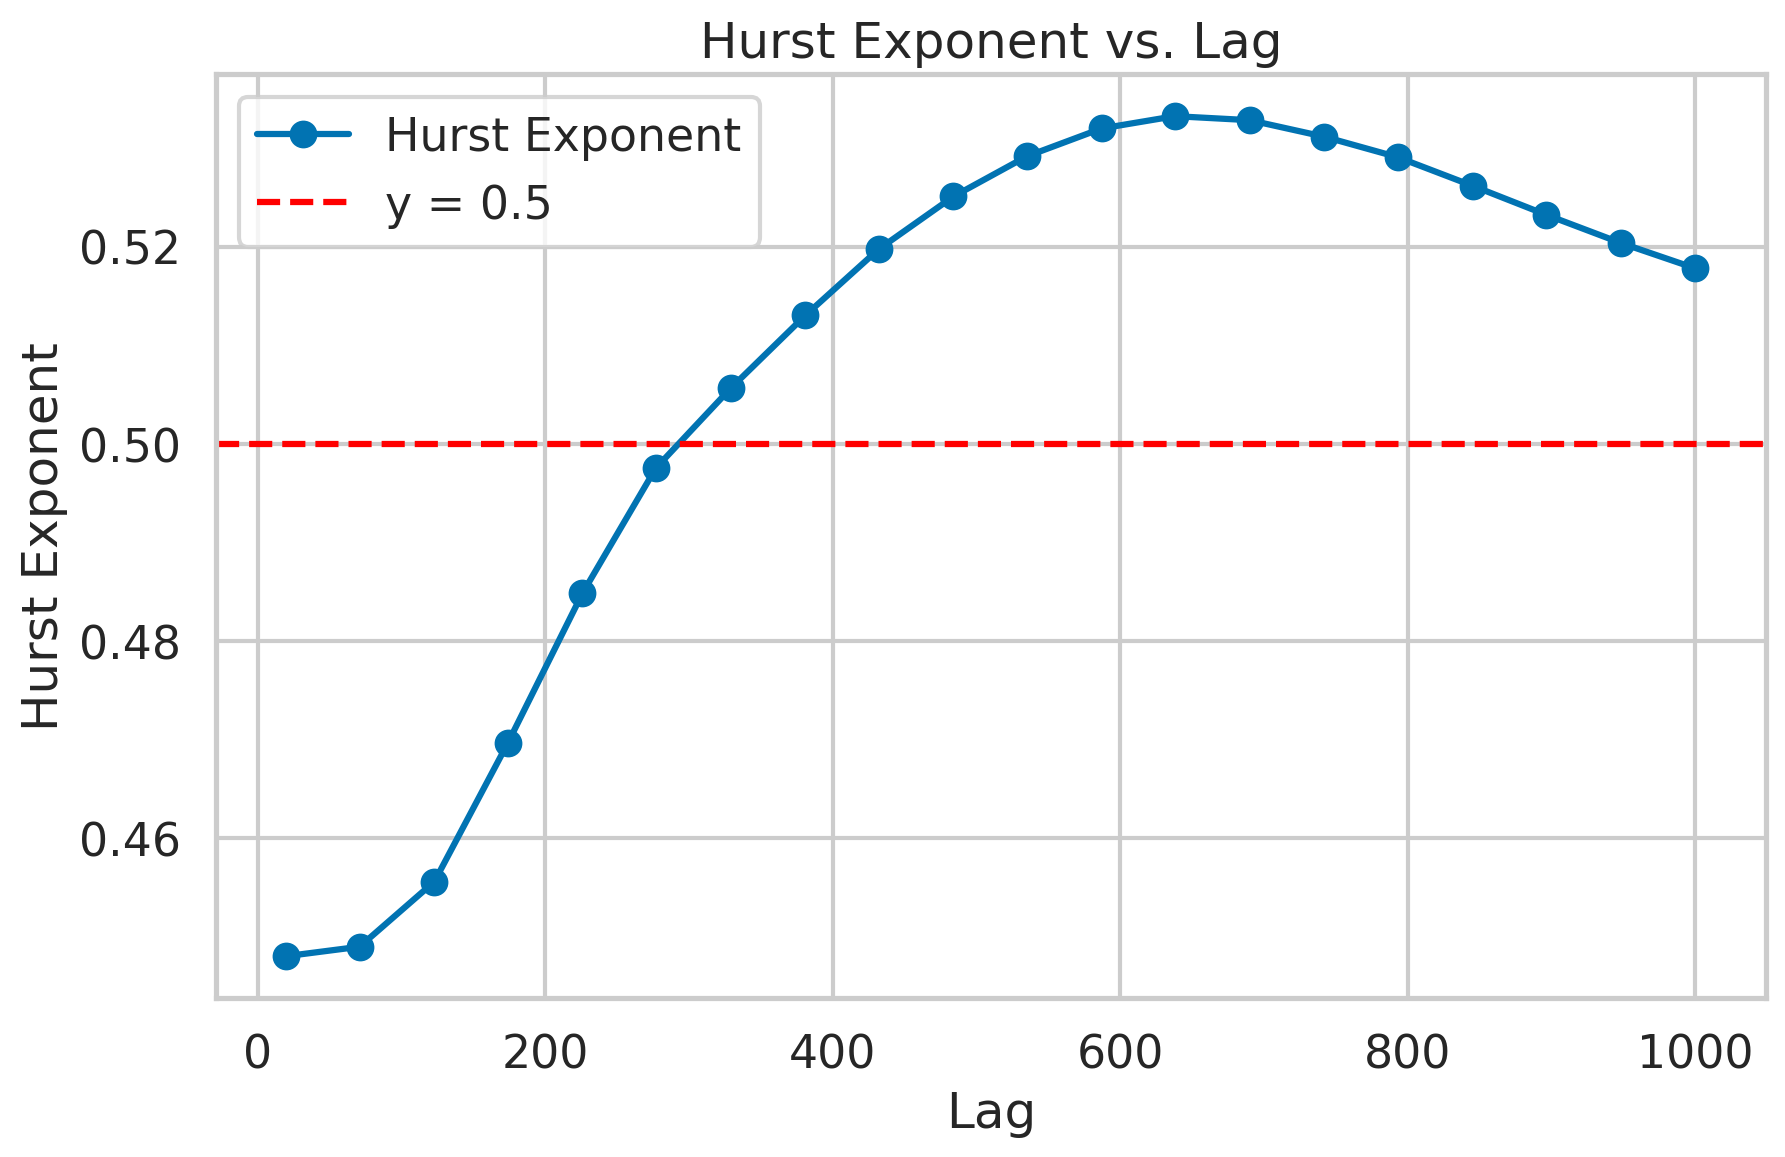

In [85]:
# 20개의 다양한 lag 값을 설정
lags = np.linspace(20, 1000, 20, dtype=int)
hurst_values = []

# 각 lag에 대해 Hurst 지수를 계산하고 저장
for lag in lags:
    hurst_exp = get_hurst_exponent(df["Adj Close"].values, lag)
    hurst_values.append(hurst_exp)

# Hurst 지수를 플롯
plt.figure(figsize=(10, 6))
plt.plot(lags, hurst_values, marker='o', label='Hurst Exponent')
plt.axhline(y=0.5, color='red', linestyle='--', label='y = 0.5')
plt.title('Hurst Exponent vs. Lag')
plt.xlabel('Lag')
plt.ylabel('Hurst Exponent')
plt.grid(True)
plt.legend()  # 범례 추가
plt.show()

Hurst 지수는 시계열 데이터가 모멘텀(추세)인지, 평균 회귀성(회귀)을 보이는지, 아니면 랜덤 워크를 따르는지를 판단하는 데 사용됩니다. 일반적으로 Hurst 지수는 다음과 같이 해석합니다:

- **H < 0.5**: 평균 회귀성을 나타냅니다.
- **H = 0.5**: 랜덤 워크(무작위 과정)입니다.
- **H > 0.5**: 추세(모멘텀)를 나타냅니다.

그래프에서 Hurst 지수는 `lag`에 따라 변동하고 있습니다. `lag` 값이 작은 경우에는 Hurst 지수가 0.5 이하로 떨어져 평균 회귀성을 보이고, `lag` 값이 증가함에 따라 Hurst 지수가 0.5 이상으로 올라가면서 모멘텀을 나타냅니다. 

**기준 설정의 중요성**
이렇게 `lag`에 따라 Hurst 지수가 변하는 것은 매우 일반적인 현상입니다. 왜냐하면 시계열 데이터가 가지는 패턴이 `lag`의 범위에 따라 다르게 해석될 수 있기 때문입니다. 예를 들어, 짧은 기간 동안의 변화는 평균 회귀성을 보일 수 있지만, 더 긴 기간 동안에는 추세를 따를 수 있습니다.

**해석 방법**
- **단기 해석**: `lag` 값이 작을 때 Hurst 지수가 0.5 이하로 나오는 경우, 단기적으로는 평균 회귀성이 강한 것으로 볼 수 있습니다. 이는 가격이 장기적으로 추세를 따르기보다는 평균으로 돌아오는 경향이 있다는 뜻입니다.
- **장기 해석**: `lag` 값이 클 때 Hurst 지수가 0.5 이상으로 나오는 경우, 장기적으로는 모멘텀(추세)을 따른다고 볼 수 있습니다. 이는 주가가 특정 방향으로 지속적인 움직임을 보일 가능성이 크다는 뜻입니다.

**결론**
Hurst 지수는 `lag`에 따라 달라지므로, 주가의 특성을 평가할 때는 단일한 `lag` 값에 의존하기보다는, 다양한 `lag` 값에서의 Hurst 지수를 모두 고려하여 판단하는 것이 좋습니다. 

따라서, 이 그래프에서는 `lag` 값에 따라 다르게 해석될 수 있지만, 전체적인 추세를 파악하기 위해서는 `lag` 값이 큰 쪽에서 Hurst 지수가 0.5 이상으로 유지되면, 주가가 장기적으로는 추세를 보인다고 판단할 수 있습니다. 반대로, `lag` 값이 작을 때 0.5 이하로 나오면 단기적으로는 평균 회귀성을 보일 가능성이 있다는 점을 함께 고려해야 합니다.

5. Narrow down the data to the years 2005-2007 and calculate the exponents one more time:

5단계에서는 유사한 실험을 수행했지만, 이번에는 제한된 시계열에 대해 진행했습니다. 2005년부터 2007년까지의 데이터만을 살펴보았습니다. 이때는 제한된 시계열 내에서 충분한 관측값이 없었기 때문에 `max_lag` 값을 1,000으로 설정하는 것을 제거해야 했습니다. 결과는 이전보다 더 크게 변했으며, `max_lag` 값이 20일 때는 0.4에서, 500일 때는 0.13으로 나타났습니다.

Hurst 지수를 사용하여 분석할 때는 다음 사항을 염두에 두어야 합니다:
- Hurst 지수를 계산하는 데 사용한 방법
- `max_lag` 파라미터의 값
- 분석 대상 기간 - 국부 패턴은 전체 패턴과 매우 다를 수 있습니다.

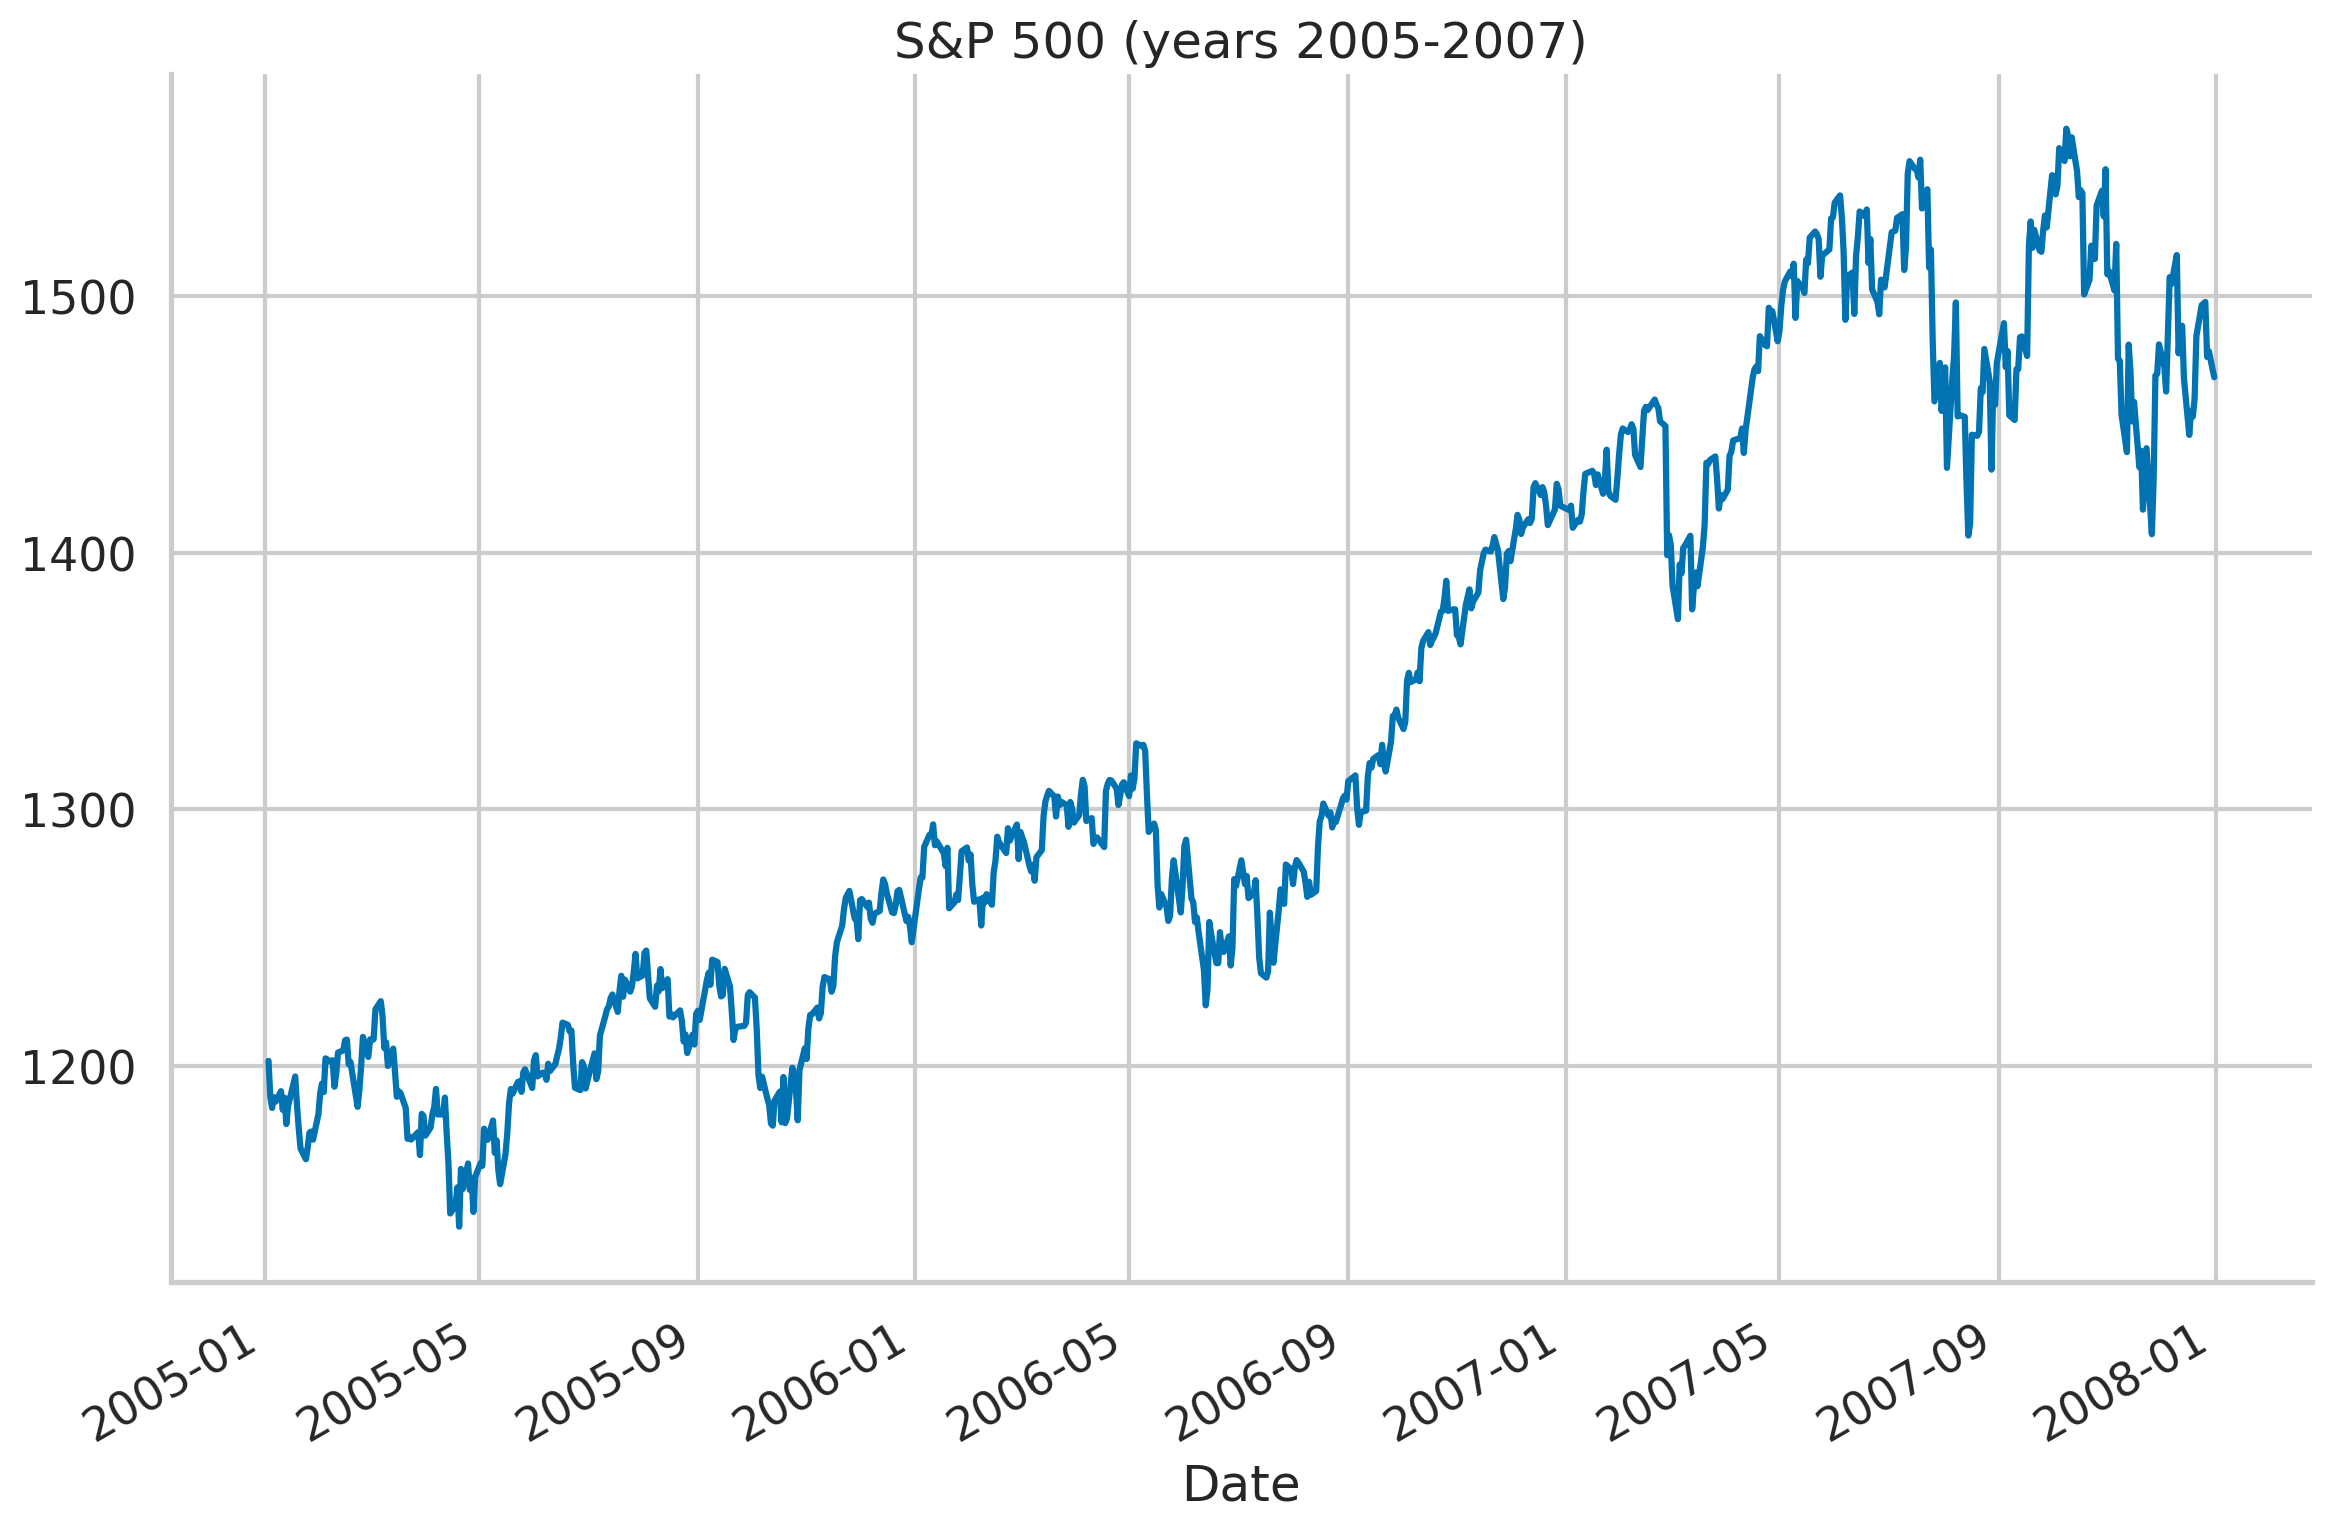

In [86]:
df.loc["2005":"2007", "Adj Close"].plot(title="S&P 500 (years 2005-2007)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_10", dpi=200);

In [59]:
shorter_series = df.loc["2005":"2007", "Adj Close"].values
for lag in [20, 100, 250, 500]:
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.3989
Hurst exponent with 100 lags: 0.3215
Hurst exponent with 250 lags: 0.2507
Hurst exponent with 500 lags: 0.1258


/home/restful3/anaconda3/envs/trading38/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/restful3/anaconda3/envs/trading38/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/restful3/anaconda3/envs/trading38/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_858428/916014612.py:10: RuntimeWarning: divide by zero encountered in log
  hurst_exp = np.polyfit(np.log(lags), np.log(tau), 1)[0]


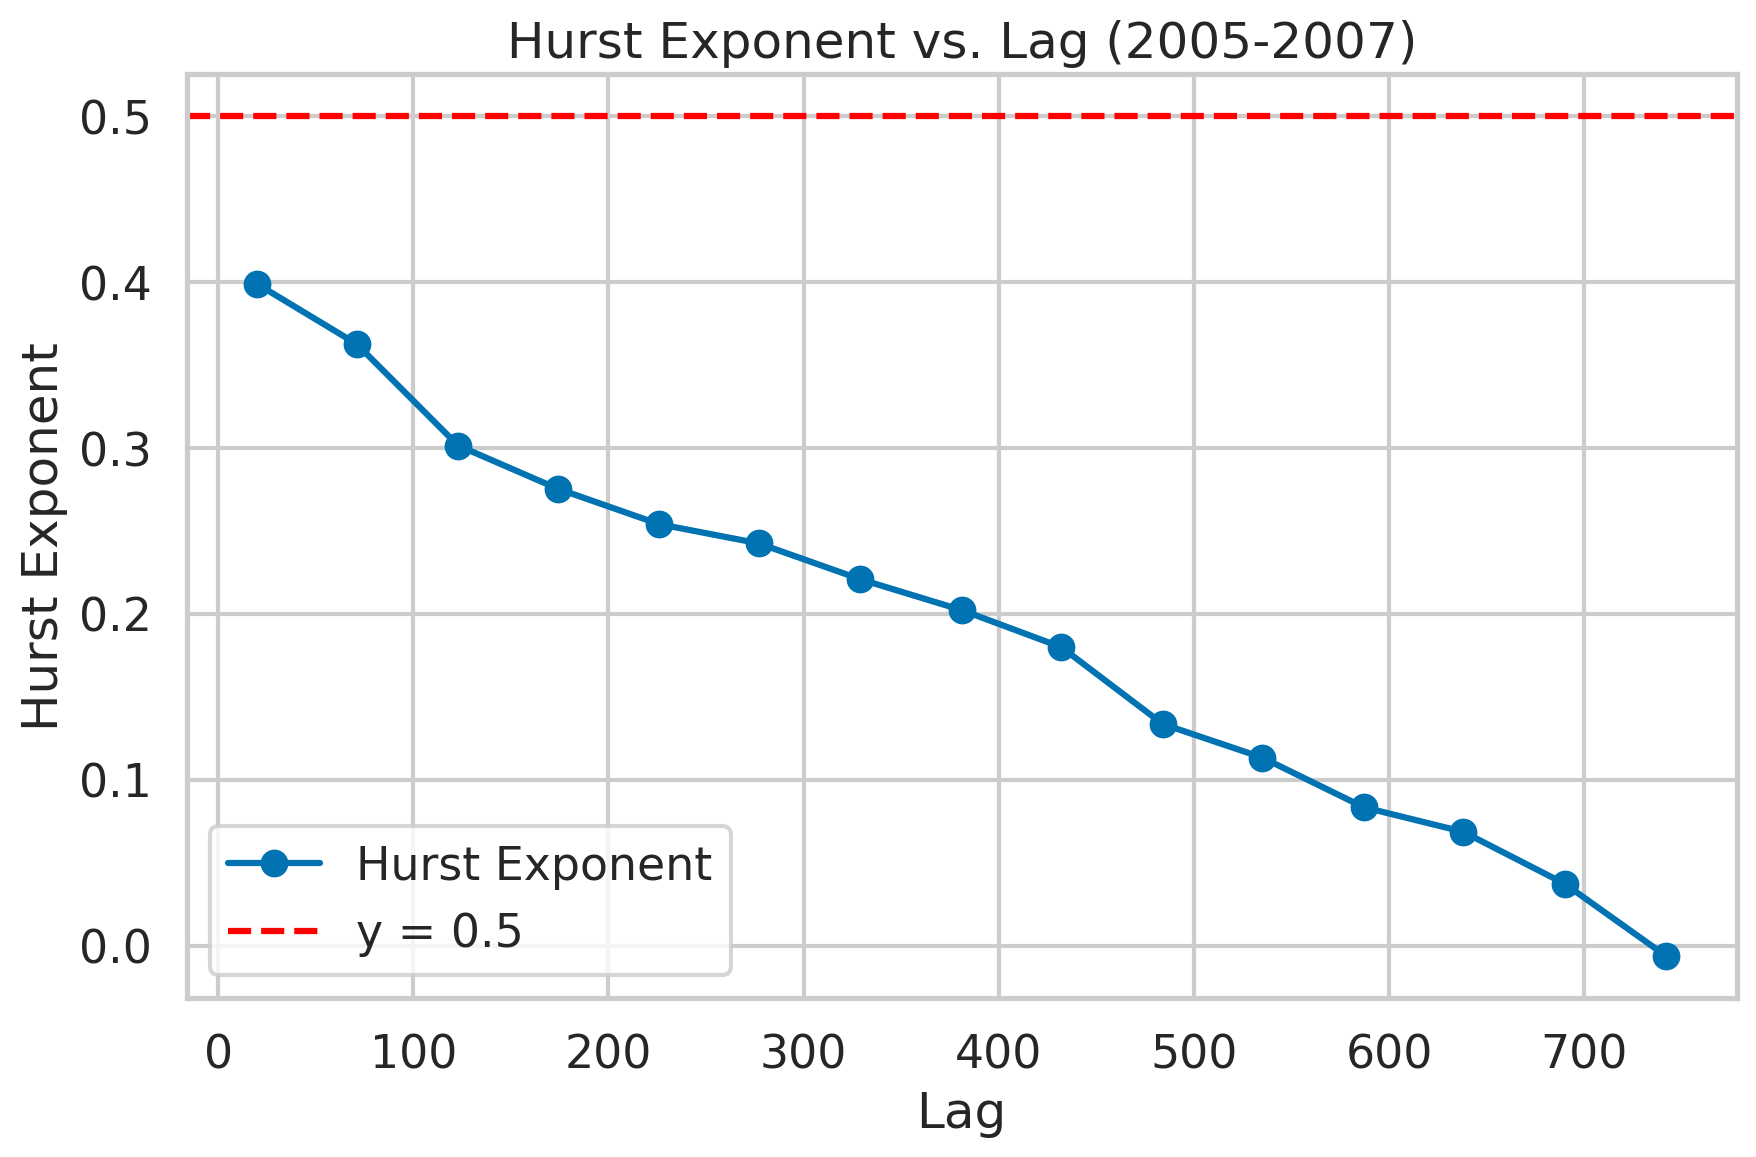

In [87]:
# 20개의 다양한 lag 값을 설정
lags = np.linspace(20, 1000, 20, dtype=int)
hurst_values = []

# "2005"년부터 "2007"년까지의 기간에 해당하는 데이터를 사용
shorter_series = df.loc["2005":"2007", "Adj Close"].values

# 각 lag에 대해 Hurst 지수를 계산하고 저장
for lag in lags:
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    hurst_values.append(hurst_exp)

# Hurst 지수를 플롯
plt.figure(figsize=(10, 6))
plt.plot(lags, hurst_values, marker='o', label='Hurst Exponent')
plt.axhline(y=0.5, color='red', linestyle='--', label='y = 0.5')
plt.title('Hurst Exponent vs. Lag (2005-2007)')
plt.xlabel('Lag')
plt.ylabel('Hurst Exponent')
plt.grid(True)
plt.legend()  # 범례 추가
plt.show()

더 알아보기...

서론에서 언급했듯이 Hurst 지수를 계산하는 방법에는 여러 가지가 있습니다. 또 다른 꽤 인기 있는 접근 방식은 **rescaled range (R/S) 분석**을 사용하는 것입니다. 간단한 문헌 검토에 따르면, R/S 통계를 사용하는 것이 자기상관 분석, 분산 비율 분석 등 다른 방법에 비해 더 나은 결과를 가져오는 것으로 보입니다. 이 방법의 잠재적인 단점은 단기 의존성에 매우 민감하다는 점입니다.

rescaled range 분석을 기반으로 한 Hurst 지수의 구현을 위해서는 `hurst` 라이브러리를 확인해 볼 수 있습니다. 아래 링크에서 `hurst` 라이브러리의 저장소를 확인할 수 있습니다.

참고:
- [hurst 라이브러리의 GitHub 저장소](https://github.com/Mottl/hurst)
- Hurst, H. E. 1951. "Long-Term Storage Capacity of Reservoirs." ASCE Transactions 116(1): 770–808.
- Kroha, P., & Skoula, M. 2018, March. "Hurst Exponent and Trading Signals Derived from Market Time Series." In ICEIS (1): 371–378.

## 4.6 Investigating stylized facts of asset returns

스타일화된 사실(Stylized facts)은 여러 실제 자산 수익률(시간과 시장을 초월하여)에서 나타나는 통계적 특성입니다. 이러한 사실을 인지하는 것이 중요한 이유는, 자산 가격 동향을 나타내기 위해 모델을 구축할 때, 모델이 이러한 특성을 포착하거나 재현할 수 있어야 하기 때문입니다. 이 레시피에서는 2000년부터 2020년까지의 일별 S&P 500 수익률 예제를 사용하여 다섯 가지 스타일화된 사실을 조사합니다.

### How to do it...

1. Import the libraries:

In [88]:
import pandas as pd 
import numpy as np
import yfinance as yf
import seaborn as sns 
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

2. Download the S&P 500 data and calculate the returns:

In [89]:
df = yf.download("^GSPC", 
                 start="2000-01-01", 
                 end="2020-12-31",
                 progress=False)

df = df[["Adj Close"]].rename(
    columns={"Adj Close": "adj_close"}
)
df["log_rtn"] = np.log(df["adj_close"]/df["adj_close"].shift(1))
df = df[["adj_close", "log_rtn"]].dropna()
df

,adj_close,log_rtn
Date,,
2000-01-04,1399.420044,-0.039099
2000-01-05,1402.109985,0.001920
2000-01-06,1403.449951,0.000955
2000-01-07,1441.469971,0.026730
2000-01-10,1457.599976,0.011128
...,...,...
2020-12-23,3690.010010,0.000746
2020-12-24,3703.060059,0.003530
2020-12-28,3735.360107,0.008685


#### Fact 1 - Non-Gaussian distribution of returns

문헌에서 (일별) 자산 수익률이 다음과 같은 특성을 보인다는 것이 관찰되었습니다:

- **음의 왜도 (세 번째 모멘트)**: 큰 음의 수익률이 큰 양의 수익률보다 더 자주 발생합니다.
- **초과 첨도 (네 번째 모멘트)**: 큰(또는 작은) 수익률이 정규 분포에서 예상되는 것보다 더 자주 발생합니다.

모멘트(Moments)는 확률 분포를 설명하기 위해 사용되는 일련의 통계적 측정값입니다. 첫 네 가지 모멘트는 다음과 같습니다: 

기대값(평균), 분산, 왜도, 첨도.

다음 단계를 실행하여 수익률의 히스토그램과 양-양(Q-Q) 플롯을 그려 첫 번째 사실의 존재를 조사해 보세요.

1. Calculate the Normal PDF using the mean and standard deviation of the observed returns:

**norm_pdf:**
- r_range 배열의 각 값에 대해, 평균 mu와 표준 편차 sigma를 가진 정규 분포의 확률 밀도를 계산합니다. 
- 이 계산의 결과로 norm_pdf는 정규 분포 곡선에 해당하는 확률 밀도 함수 값을 가지는 배열이 됩니다.

In [90]:
r_range = np.linspace(min(df["log_rtn"]), 
                      max(df["log_rtn"]), 
                      num=1000)
mu = df["log_rtn"].mean()
sigma = df["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)   

2. Plot the histogram and the Q-Q Plot:

/tmp/ipykernel_858428/1568670105.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.log_rtn, kde=False,


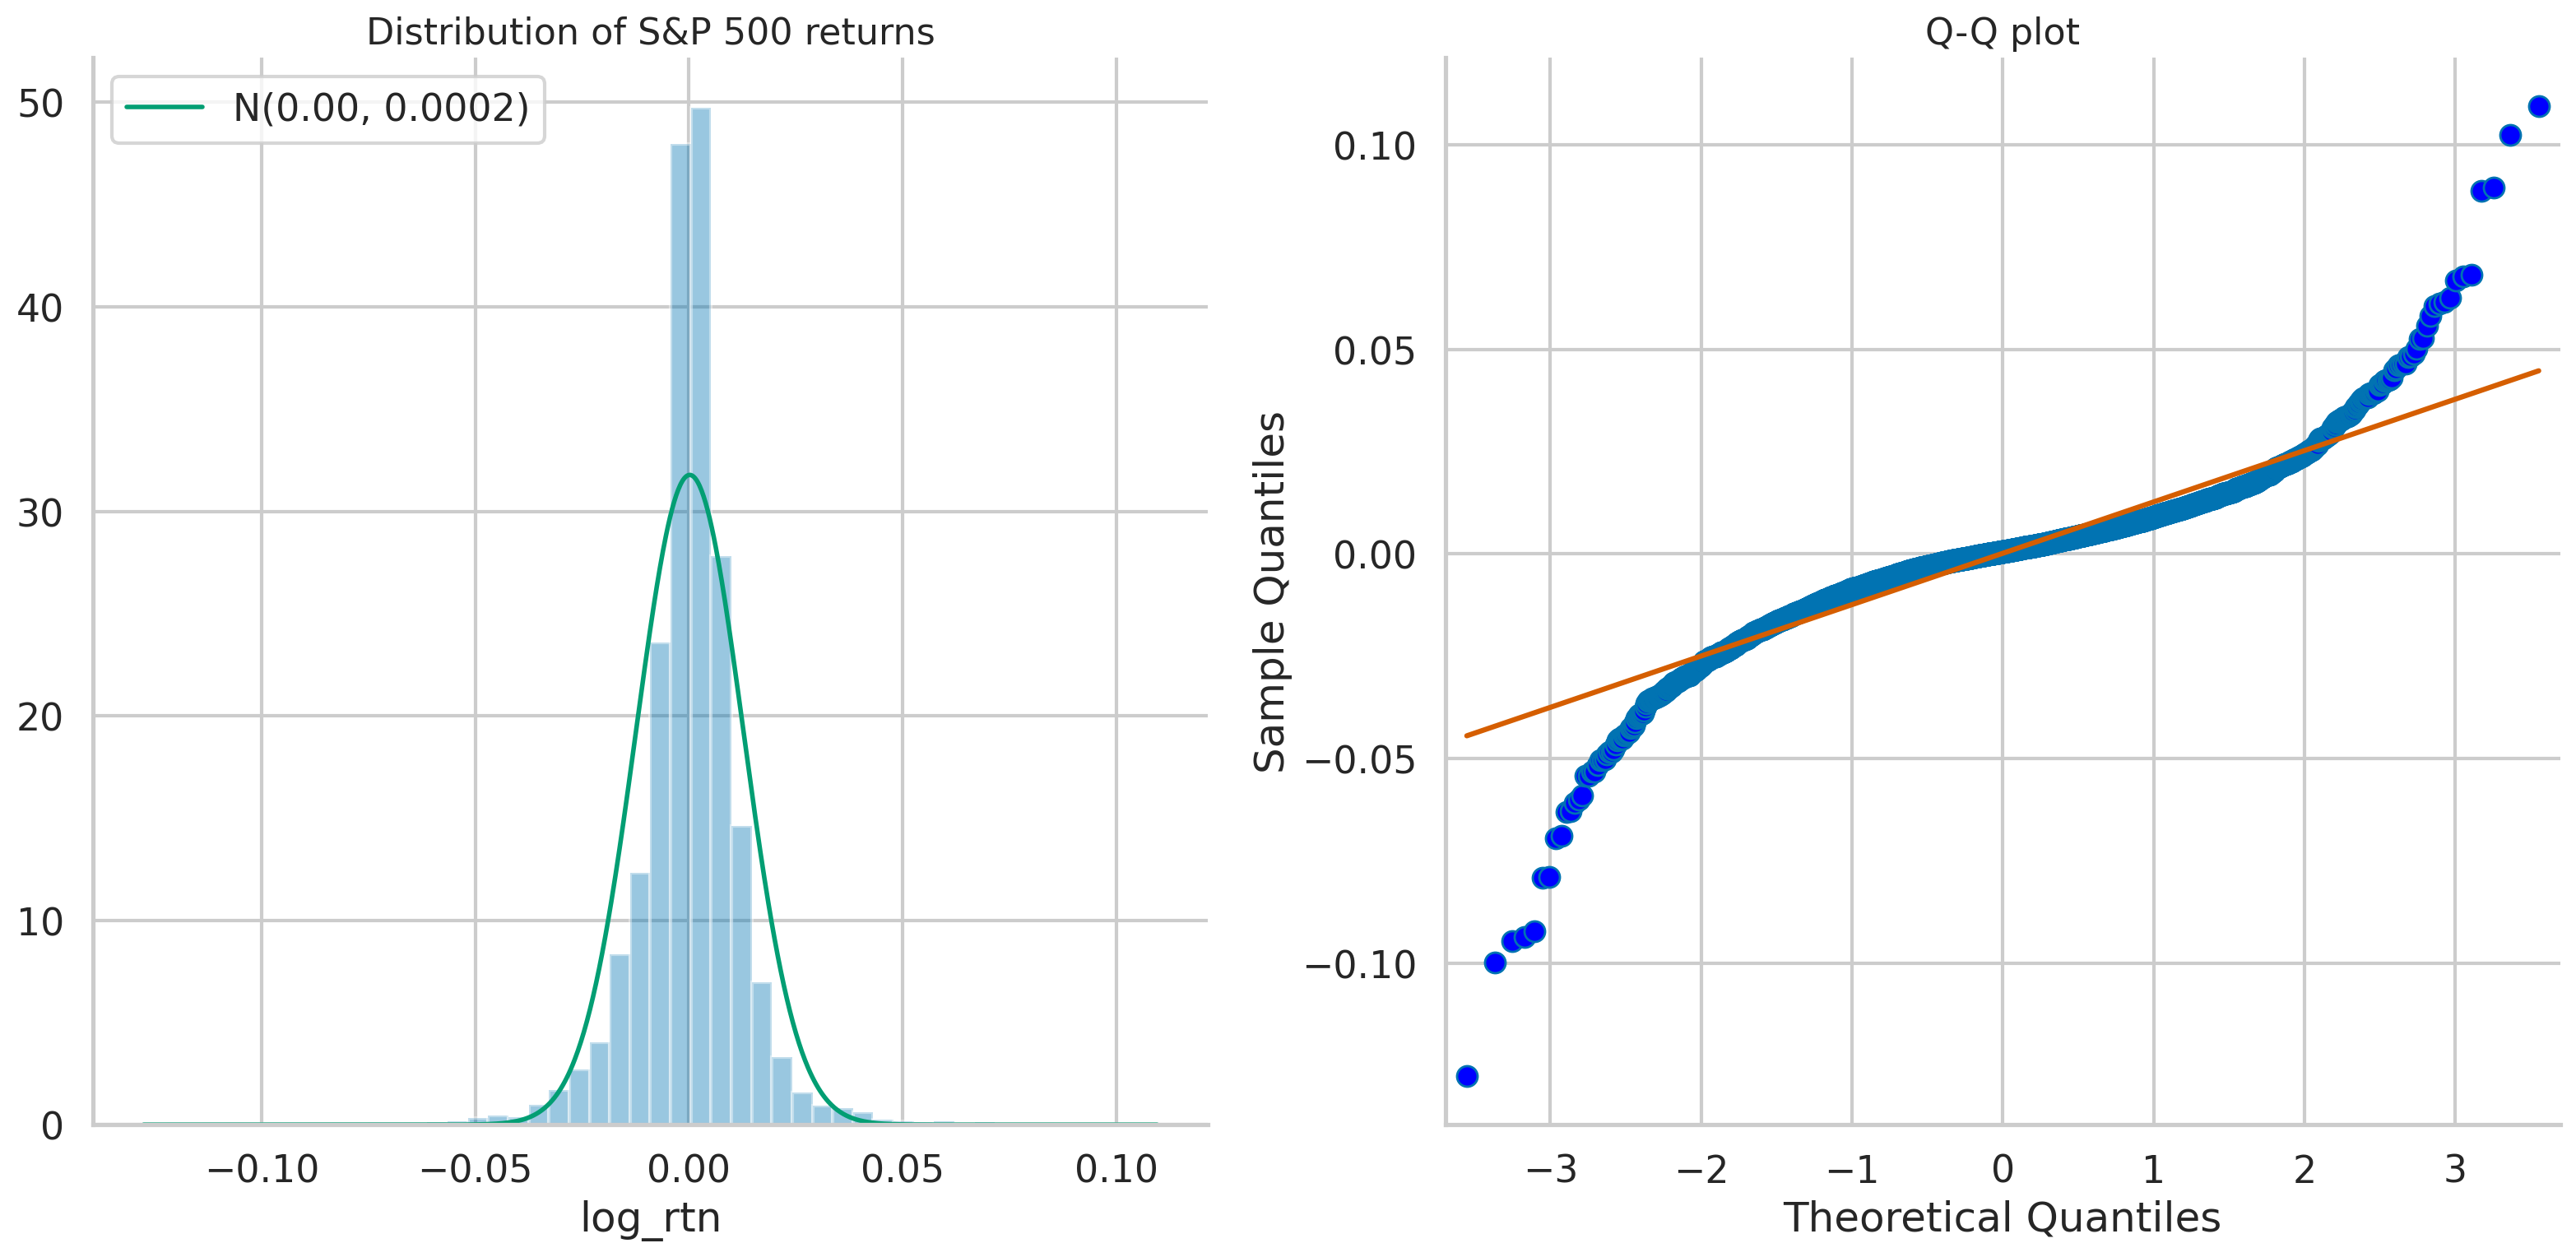

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# 히스토그램
sns.distplot(df.log_rtn, kde=False, 
             norm_hist=True, ax=ax[0])  # S&P 500 로그 수익률의 히스토그램을 생성합니다.
ax[0].set_title("Distribution of S&P 500 returns", 
                fontsize=16)  # 첫 번째 플롯의 제목을 설정합니다.
ax[0].plot(r_range, norm_pdf, "g", lw=2, 
           label=f"N({mu:.2f}, {sigma**2:.4f})")  # 계산된 정규 분포의 확률 밀도 함수를 히스토그램 위에 플롯합니다.
ax[0].legend(loc="upper left");  # 범례를 히스토그램의 왼쪽 상단에 추가합니다.

# Q-Q 플롯
qq = sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])  # 로그 수익률의 Q-Q 플롯을 생성합니다.
ax[1].set_title("Q-Q plot", fontsize = 16)  # 두 번째 플롯의 제목을 설정합니다.

sns.despine()  # 플롯의 상단과 오른쪽 경계를 제거하여 깔끔하게 만듭니다.
plt.tight_layout()  # 플롯의 레이아웃을 자동으로 조정하여 요소들이 겹치지 않도록 합니다.
# plt.savefig("images/figure_4_11", dpi=200);  # 플롯을 파일로 저장하는 코드 (현재는 주석 처리되어 있음).

**수익률의 히스토그램**

이 사실을 조사하기 위한 첫 번째 단계는 수익률의 분포를 시각화하여 히스토그램을 그리는 것이었습니다. 이를 위해 `sns.distplot`을 사용했으며, `kde=False`(가우시안 커널 밀도 추정을 사용하지 않음)와 `norm_hist=True`(빈도 대신 밀도를 표시)를 설정했습니다. 히스토그램과 가우시안 분포의 차이를 확인하기 위해, PDF(확률 밀도 함수)를 나타내는 선을 히스토그램 위에 겹쳤습니다. 이 PDF는 고려된 수익률 시계열의 평균과 표준 편차를 사용하여 계산했습니다. 먼저, `np.linspace`를 사용하여 PDF를 계산할 범위를 지정했습니다(포인트 수를 1,000으로 설정했습니다. 일반적으로 포인트 수가 많을수록 선이 더 매끄러워집니다). 그런 다음 `scs.norm.pdf` 함수를 사용하여 PDF를 계산했습니다. 기본 인수는 평균이 0이고 분산이 1인 표준 정규 분포에 해당합니다. 따라서 `loc`와 `scale` 인수를 각각 샘플 평균과 표준 편차로 지정했습니다.

이전에 언급한 패턴의 존재를 확인하려면 다음을 살펴봐야 합니다:
- **음의 왜도**: 분포의 왼쪽 꼬리가 길고, 분포의 질량이 오른쪽에 집중되어 있음
- **초과 첨도**: 꼬리가 두껍고 정점이 뾰족한 분포

두 번째 포인트는 우리의 플롯에서 더 쉽게 관찰할 수 있는데, PDF에 비해 명확한 정점이 있고, 꼬리에 더 많은 질량이 있는 것을 볼 수 있습니다.

**Q-Q 플롯**

히스토그램을 살펴본 후, Q-Q 플롯을 확인했습니다. 이 플롯에서는 두 분포(이론적 분포와 관측된 분포)를 비교하여 각각의 분위수를 플롯합니다. 우리의 경우, 이론적 분포는 가우시안(정규) 분포이며, 관측된 분포는 S&P 500 수익률에서 가져온 것입니다. 플롯을 얻기 위해 `sm.qqplot` 함수를 사용했습니다. 경험적 분포가 정규 분포라면, 대부분의 점들이 빨간 선 위에 위치할 것입니다. 그러나 실제로는 그렇지 않으며, 플롯의 왼쪽에 있는 점들은 예상보다 더 음의 값(즉, 더 작은 분위수)을 가집니다. 이는 수익률 분포의 왼쪽 꼬리가 가우시안 분포보다 더 두껍다는 것을 의미합니다. 오른쪽 꼬리에 대해서도 비슷한 결론을 내릴 수 있으며, 이는 정규성 하에서보다 더 두껍습니다.

3. Print the summary statistics of the log returns:

In [64]:
jb_test = scs.jarque_bera(df["log_rtn"].values)

print("---------- Descriptive Statistics ----------")
print("Range of dates:", min(df.index.date), "-", max(df.index.date))
print("Number of observations:", df.shape[0])
print(f"Mean: {df.log_rtn.mean():.4f}")
print(f"Median: {df.log_rtn.median():.4f}")
print(f"Min: {df.log_rtn.min():.4f}")
print(f"Max: {df.log_rtn.max():.4f}")
print(f"Standard Deviation: {df.log_rtn.std():.4f}")
print(f"Skewness: {df.log_rtn.skew():.4f}")
print(f"Kurtosis: {df.log_rtn.kurtosis():.4f}") 
print(f"Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}")

---------- Descriptive Statistics ----------
Range of dates: 2000-01-04 - 2020-12-30
Number of observations: 5282
Mean: 0.0002
Median: 0.0006
Min: -0.1277
Max: 0.1096
Standard Deviation: 0.0126
Skewness: -0.3935
Kurtosis: 10.9538
Jarque-Bera statistic: 26487.80 with p-value: 0.00


평균, 표준 편차, 왜도, 첨도와 같은 지표를 살펴보면, 이들이 정규성 하에서 기대되는 값과 다르다는 것을 알 수 있습니다. 표준 정규 분포의 네 가지 모멘트(순서대로 평균, 표준 편차, 왜도, 첨도)는 각각 0, 1, 0, 0입니다. 추가적으로, Jarque-Bera 정규성 검정은 분포가 99% 신뢰 수준에서 정규 분포임을 귀무 가설로 채택할 이유가 없다고 말하며, 귀무 가설을 기각할 근거를 제공합니다. 수익률이 정규 분포를 따르지 않는다는 사실은 매우 중요합니다. 많은 통계 모델과 접근법이 랜덤 변수가 정규 분포를 따른다고 가정하기 때문입니다.

**기술 통계**

마지막 부분은 몇 가지 통계를 살펴보는 것입니다. 이를 위해 pandas Series/DataFrames의 적절한 메서드를 사용하여 계산했습니다. 즉시 확인할 수 있듯이, 수익률은 음의 왜도와 초과 첨도를 나타냅니다. 또한 Jarque-Bera 검정(`scs.jarque_bera`)을 실행하여 수익률이 가우시안 분포를 따르지 않는다는 것을 확인했습니다. p-값이 0이므로, 샘플 데이터가 가우시안 분포의 왜도와 첨도를 가지고 있다는 귀무 가설을 기각했습니다. pandas의 첨도 구현은 문헌에서 초과

#### Fact 2 - Volatility Clustering

스타일화된 사실을 조사할 때 알아두어야 할 또 다른 사항은 변동성 클러스터링입니다. 이는 높은 수익률과 낮은 수익률이 교차하는 시기를 의미하며, 변동성이 일정하지 않다는 것을 암시합니다. 이 사실을 빠르게 조사하기 위해, pandas DataFrame의 plot 메서드를 사용하여 수익률을 플롯했습니다.

변동성 클러스터링(Volatility clustering)은 큰 가격 변동이 큰 변동을 동반하는 경향이 있고(즉, 높은 변동성의 시기), 작은 가격 변동이 작은 변동을 동반하는 경향이 있는(즉, 낮은 변동성의 시기) 패턴을 말합니다.
- 변동성 클러스터링(Volatility clustering)은 주가가 크게 변동하면 그 뒤에도 큰 변동이 이어지고, 작게 변동하면 그 뒤에도 작은 변동이 이어지는 현상을 말합니다.

1. Run the following code to visualize the log returns series:

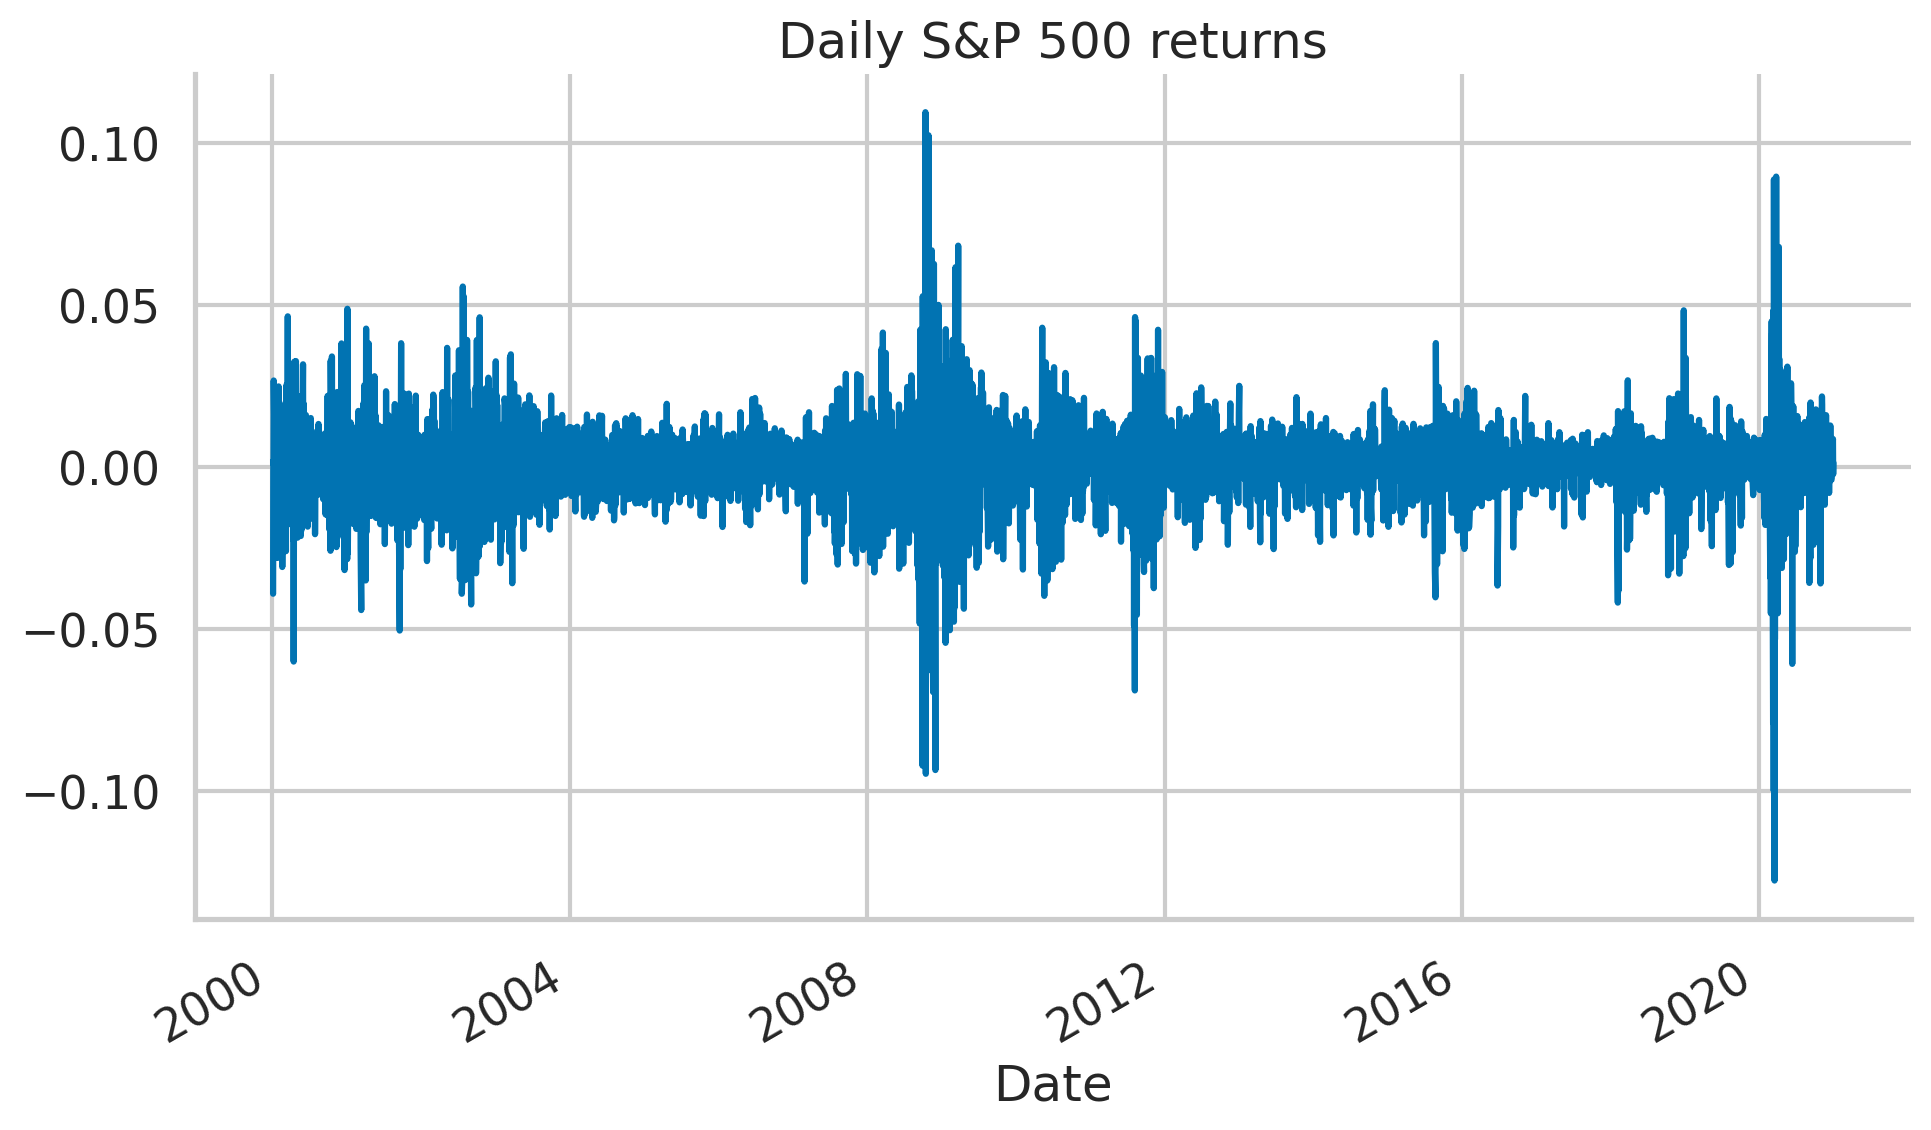

In [93]:
(
    df["log_rtn"]
    .plot(title="Daily S&P 500 returns", figsize=(10, 6))
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_12", dpi=200);

- 우리는 높은 긍정적 또는 부정적 수익률이 나타나는 명확한 변동성 클러스터를 관찰할 수 있습니다. 변동성이 일정하지 않고, 변동성이 어떻게 변화하는지에 대한 일정한 패턴이 있다는 사실은 변동성을 예측할 때 매우 유용한 관찰입니다. 예를 들어, GARCH 모델을 사용하여 변동성을 예측할 때 이러한 관찰이 도움이 됩니다. 더 자세한 내용은 9장, "GARCH 클래스 모델을 사용한 변동성 모델링"을 참조하세요.

#### Fact 3 - Absence of autocorrelation in returns

자기상관(Autocorrelation, 일명 시차 상관)은 주어진 시계열이 연속적인 시간 간격 동안 시차를 둔 자기 자신과 얼마나 유사한지를 측정하는 지표입니다.

수익률에 유의미한 자기상관이 있는지 조사하기 위해, statsmodels 라이브러리의 plot_acf를 사용하여 자기상관 플롯을 만들었습니다. 50개의 시차를 검사했으며, 기본 설정인 alpha=0.05를 사용했습니다. 이는 95% 신뢰 구간도 함께 플롯했다는 것을 의미합니다. 이 구간 밖의 값들은 통계적으로 유의미한 것으로 간주될 수 있습니다.

1. Define the parameters for creating the autocorrelation plots:

In [94]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

2. Run the following code to create ACF plot of log returns:

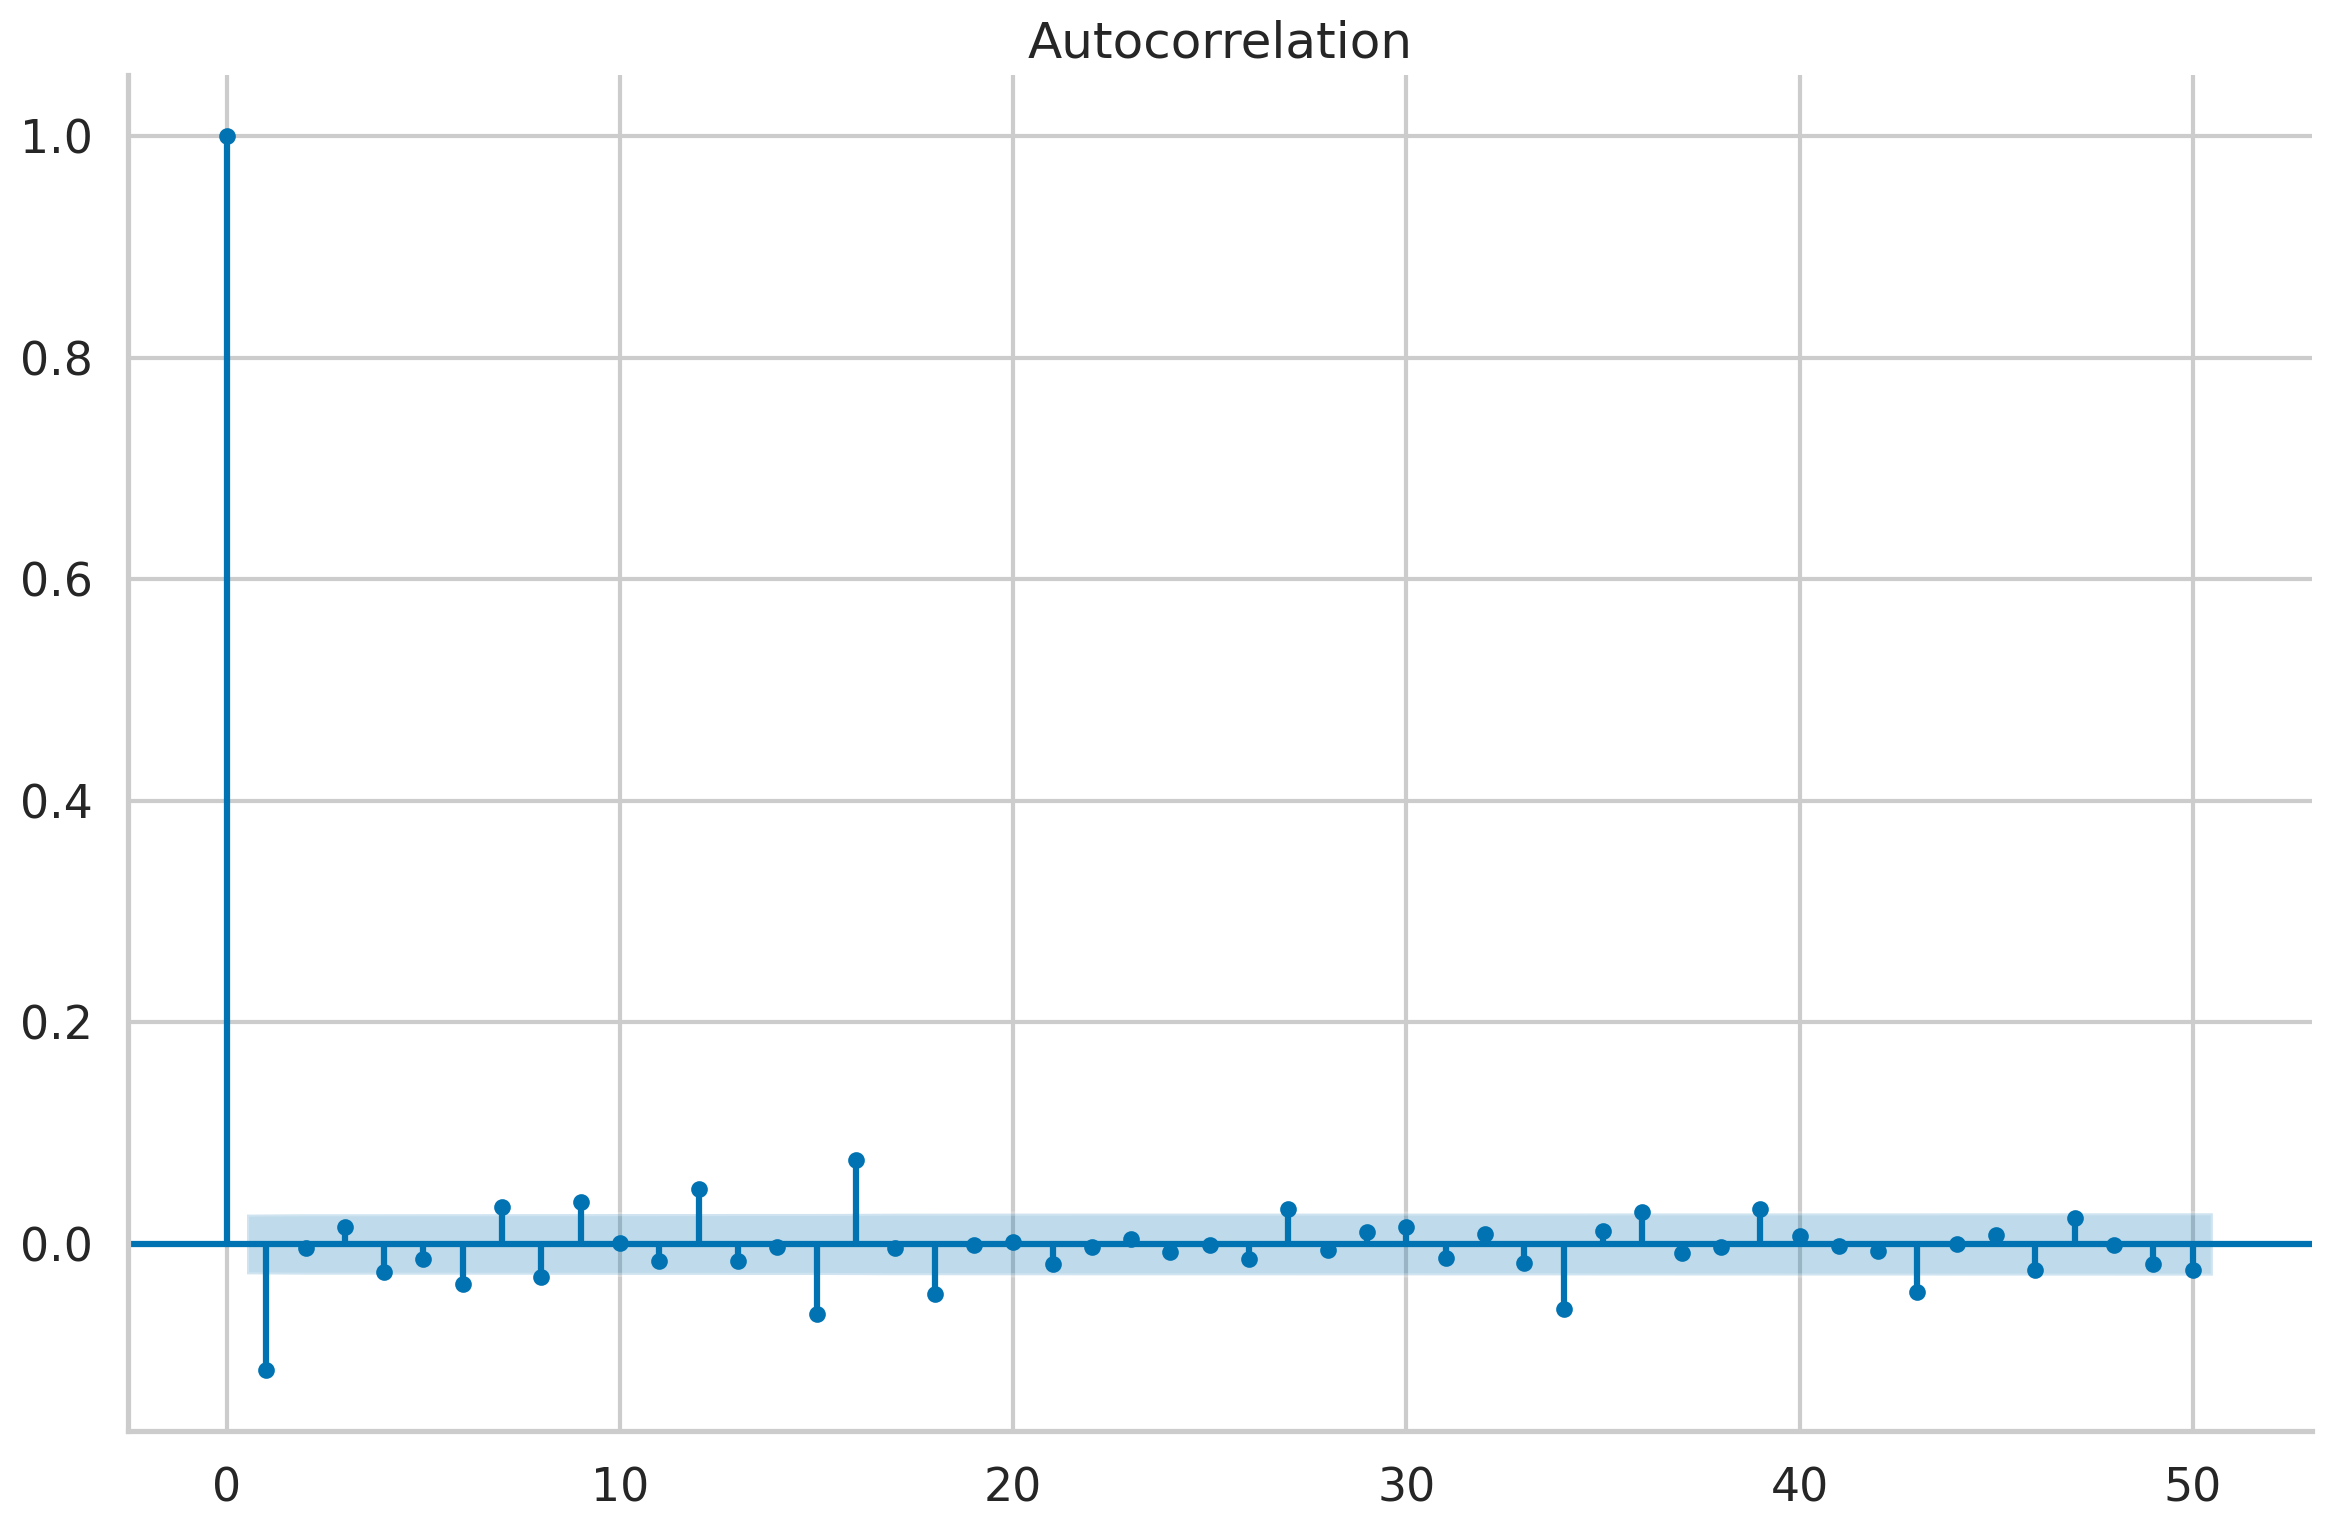

In [95]:
acf = smt.graphics.plot_acf(df["log_rtn"], 
                            lags=N_LAGS, 
                            alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_13", dpi=200);

몇몇 값들만 신뢰 구간 밖에 위치하며(시차 0은 고려하지 않습니다), 통계적으로 유의미하다고 볼 수 있습니다. 따라서 로그 수익률 시계열에 자기상관이 없음을 확인했다고 가정할 수 있습니다.

**그래프 분석**

**1. 시차 0에서의 값**:
   - 시차 0에서는 자기상관 계수가 항상 1입니다. 이는 데이터가 자기 자신과 100% 상관이 있기 때문입니다. 따라서 시차 0의 값을 해석할 때는 특별한 의미가 없습니다.

**2. 시차 1 이상의 값**:
   - 시차 1 이상에서 대부분의 값이 0에 가까우며, 신뢰 구간(보통 ±2표준오차 범위) 내에 위치해 있습니다. 이는 통계적으로 유의미하지 않은 자기상관을 나타냅니다.
   - 몇몇 시차에서 자기상관 계수가 신뢰 구간을 벗어나 있지만, 이는 전체적인 패턴에 큰 영향을 미치지 않는 것으로 보입니다.

**자기상관이 없는 이유**

로그 수익률 시계열에서 자기상관이 거의 없는 이유는 **효율적 시장 가설(EMH)** 때문일 수 있습니다. 이 가설에 따르면, 시장에서 주가가 모든 가용 정보를 반영하고 있기 때문에 과거의 가격 변동(또는 수익률)을 바탕으로 미래의 변동을 예측할 수 없습니다. 따라서 수익률 시계열은 본질적으로 랜덤 워크(Random Walk)와 유사하게 행동하며, 자기상관이 없거나 매우 약하게 나타나는 경우가 많습니다.

**결론**

그래프에서 확인할 수 있듯이, 로그 수익률 시계열은 대부분의 시차에서 자기상관이 거의 없음을 보여줍니다. 이는 로그 수익률이 랜덤 워크를 따르고, 과거의 정보로 미래의 수익률을 예측할 수 없다는 점에서 자기상관이 없다는 결론을 내릴 수 있습니다.

#### Fact 4 - Small and decreasing autocorrelation in squared/absolute returns

자기상관(Autocorrelation, 지속성이라고도 함)은 절대 수익률이나 제곱 수익률과 같은 간단한 비선형 함수에서 나타납니다. 이 관찰은 우리가 이미 조사한 변동성 클러스터링 현상과 연결되어 있습니다. 제곱 수익률의 자기상관 함수는 변동성 클러스터링의 일반적인 측정 도구이며, ARCH 효과라고도 불립니다. 이는 (G)ARCH 모델의 핵심 요소로, 9장 "GARCH 클래스 모델을 사용한 변동성 모델링"에서 다룹니다. 그러나 이 특성은 모델에 의존하지 않으며, GARCH 클래스 모델에만 국한된 것이 아님을 염두에 두어야 합니다.

이 사실을 확인하기 위해, statsmodels 라이브러리의 plot_acf 함수를 사용했습니다. 그러나 이번에는 제곱 및 절대 수익률에 적용했습니다.

1. 자기상관(Autocorrelation)이란?
   - 간단히 말해, 시간의 흐름에 따른 데이터의 패턴이 스스로 반복되는 현상입니다.
   - 금융에서는 주로 수익률의 절대값이나 제곱값에서 이러한 패턴이 나타납니다.

2. 변동성 클러스터링과의 연관성
   - 변동성 클러스터링: 주식 시장에서 큰 변동이 있는 시기가 몰려서 나타나는 현상
   - 자기상관은 이 변동성 클러스터링을 측정하는 데 사용됩니다.

3. ARCH 효과
   - 수익률의 제곱값에서 나타나는 자기상관을 특별히 ARCH 효과라고 부릅니다.
   - 이는 시장의 변동성이 시간에 따라 어떻게 변하는지를 보여주는 지표입니다.

4. GARCH 모델과의 관계
   - GARCH 모델은 이러한 ARCH 효과를 모델링하기 위해 만들어졌습니다.
   - 하지만 ARCH 효과 자체는 GARCH 모델에만 국한된 것이 아니라, 시장에서 실제로 관찰되는 현상입니다.

요약하자면, 자기상관은 금융 시장에서 변동성의 패턴을 이해하는 데 중요한 개념이며, 이는 여러 금융 모델의 기초가 되지만 특정 모델에 국한되지 않는 실제 시장의 특성입니다.

1. Create the ACF plots:

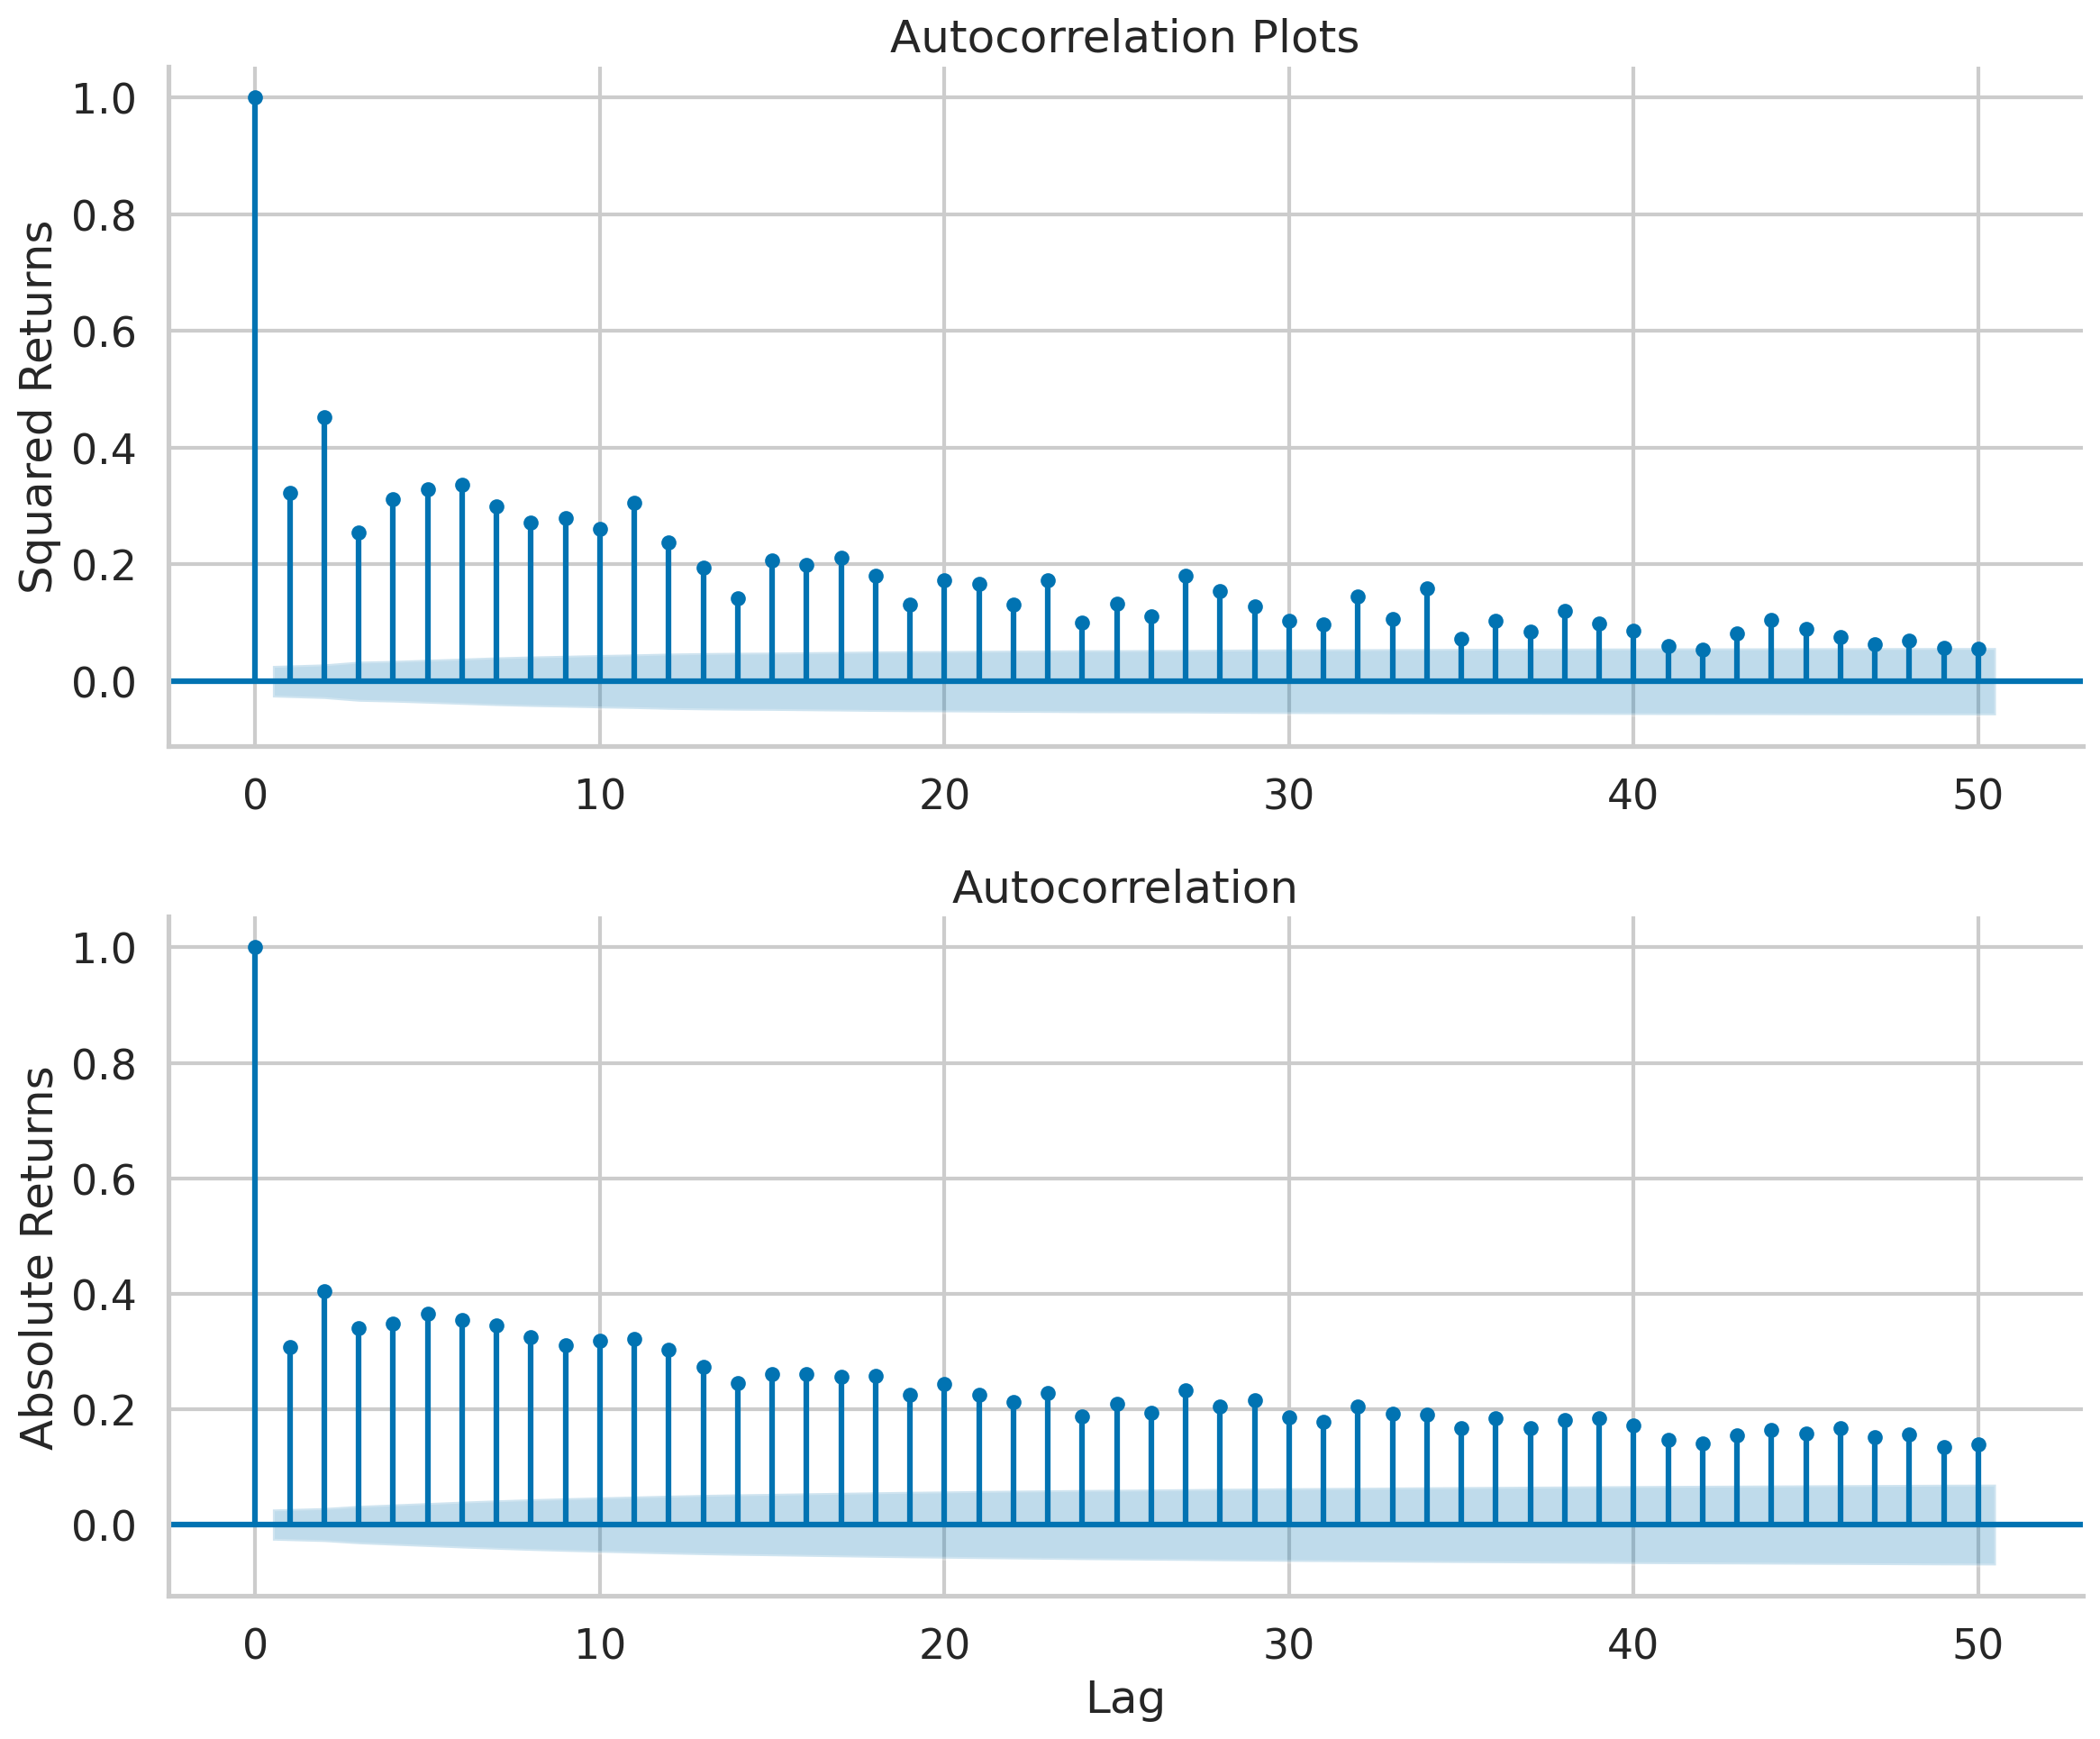

In [96]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# 제곱 수익률의 자기상관 함수(ACF) 플롯
smt.graphics.plot_acf(df["log_rtn"]**2, lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title="Autocorrelation Plots",  # 첫 번째 플롯의 제목 설정
          ylabel="Squared Returns")  # 첫 번째 플롯의 y축 라벨 설정

# 절대 수익률의 자기상관 함수(ACF) 플롯
smt.graphics.plot_acf(np.abs(df["log_rtn"]), lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel="Absolute Returns",  # 두 번째 플롯의 y축 라벨 설정
          xlabel="Lag")  # 두 번째 플롯의 x축 라벨 설정

sns.despine()  # 플롯의 상단과 오른쪽 경계를 제거하여 깔끔하게 만듭니다.
plt.tight_layout()  # 플롯의 레이아웃을 자동으로 조정하여 요소들이 겹치지 않도록 합니다.
# plt.savefig("images/figure_4_14", dpi=200);  # 플롯을 파일로 저장하는 코드 (현재는 주석 처리되어 있음).

제곱 수익률과 절대 수익률에 대해 작은 값의 자기상관이 나타나며, 이는 점차 감소하는 경향을 보입니다. 이는 네 번째 스타일화된 사실과 일치합니다.

**제곱 수익률의 자기상관 (첫 번째 그래프)**
- **패턴**: 첫 번째 그래프에서 제곱 수익률의 자기상관 계수는 초기 시차에서 높은 값을 보이며, 시차가 커짐에 따라 점차 감소하는 경향이 있습니다.
- **의미**: 이는 변동성 클러스터링 현상을 반영합니다. 즉, 변동성이 높은 시기에는 이후에도 변동성이 높을 가능성이 크며, 이로 인해 제곱 수익률에 자기상관이 발생합니다. 제곱 수익률의 자기상관 함수는 변동성 클러스터링의 대표적인 지표이며, 이러한 패턴이 나타나는 것은 변동성의 지속성을 의미합니다.
- **연결**: 이 현상은 ARCH(Autoregressive Conditional Heteroskedasticity) 효과로 알려져 있으며, GARCH 모델과 같은 변동성 모델에서 중요한 역할을 합니다.

**절대 수익률의 자기상관 (두 번째 그래프)**
- **패턴**: 두 번째 그래프에서 절대 수익률의 자기상관 계수 역시 초기 시차에서 높은 값을 보이고, 시차가 커질수록 감소하는 경향을 보입니다.
- **의미**: 절대 수익률의 자기상관도 변동성 클러스터링을 나타내며, 이는 수익률의 크기에 따라 변동성이 일정한 패턴을 따르는 것을 의미합니다. 이 역시 변동성의 지속성을 보여주는 중요한 지표입니다.

**결론**
- 이 두 그래프는 모두 **변동성 클러스터링** 현상을 잘 보여주고 있습니다. 초기 시차에서 높은 자기상관 계수는 과거의 큰 변동성이 이후에도 큰 변동성을 유발할 가능성이 있음을 시사합니다. 이와 같은 패턴은 많은 금융 시계열 데이터에서 관찰되며, 이는 GARCH 모델과 같은 변동성 예측 모델이 효과적으로 작동할 수 있는 이유 중 하나입니다.
- 따라서, 제곱 수익률과 절대 수익률의 자기상관이 모두 감소하지만 여전히 유의미한 수준으로 남아 있는 것은 네 번째 스타일화된 사실과 일치하며, 이는 변동성이 일정 기간 동안 지속된다는 것을 의미합니다.

#### Fact 5 - Leverage effect

레버리지 효과(Leverage effect)는 자산의 변동성 측정치가 대부분 해당 자산의 수익률과 음의 상관관계를 가진다는 사실을 의미합니다.

이 사실은 대부분의 자산 변동성 측정치가 수익률과 음의 상관관계를 가진다는 것을 의미합니다. 이를 조사하기 위해, pandas DataFrame의 rolling 메서드를 사용하여 계산한 이동 표준 편차를 과거 변동성의 측정치로 사용했습니다. 우리는 21일과 252일의 창을 사용했으며, 이는 각각 한 달과 1년의 거래 데이터를 나타냅니다.

**레버리지 효과의 작동 원리**

레버리지 효과는 기업의 자본 구조와 관련이 있습니다. 일반적으로 기업은 자산과 부채로 이루어진 자본 구조를 가지고 있습니다. 주가가 하락하면, 기업의 자산 가치가 줄어들어 부채 비율이 상대적으로 높아지게 됩니다. 이로 인해 기업의 레버리지(부채의 비율)가 증가하게 됩니다.

레버리지가 증가하면, 기업의 재무 구조가 더 불안정해지고, 이에 따라 미래 수익에 대한 불확실성이 커집니다. 이 불확실성은 시장에서 더 높은 변동성으로 반영됩니다. 결과적으로, 주가가 하락할 때 변동성은 증가하게 되며, 이는 레버리지 효과의 근본적인 메커니즘입니다.

**음의 상관관계**

레버리지 효과는 자산의 수익률과 변동성 사이의 음의 상관관계로 나타납니다. 즉, 주가가 하락할 때(수익률이 음수일 때) 변동성이 증가하고, 주가가 상승할 때(수익률이 양수일 때) 변동성이 감소하는 경향이 있습니다.

이러한 현상은 금융 시장에서 매우 중요한 의미를 가지며, 특히 변동성을 예측하거나 관리하는 데 중요한 역할을 합니다. 예를 들어, GARCH 모델과 같은 변동성 모델에서 이 레버리지 효과를 반영하여 변동성의 비대칭성을 고려할 수 있습니다.

**결론**

레버리지 효과는 주가 하락이 변동성을 증가시키는 중요한 금융 현상입니다. 이는 기업의 레버리지 비율 변화와 관련이 있으며, 수익률과 변동성 사이의 음의 상관관계로 나타납니다. 이러한 효과를 이해하고 반영하는 것은 금융 시장의 위험을 관리하고 예측하는 데 필수적입니다.

1. Calculate volatility measures as moving standard deviations

In [97]:
df["rolling_std_252"] = df[["log_rtn"]].rolling(window=252).std()
df["rolling_std_21"] = df[["log_rtn"]].rolling(window=21).std()

2. Plot all the series:

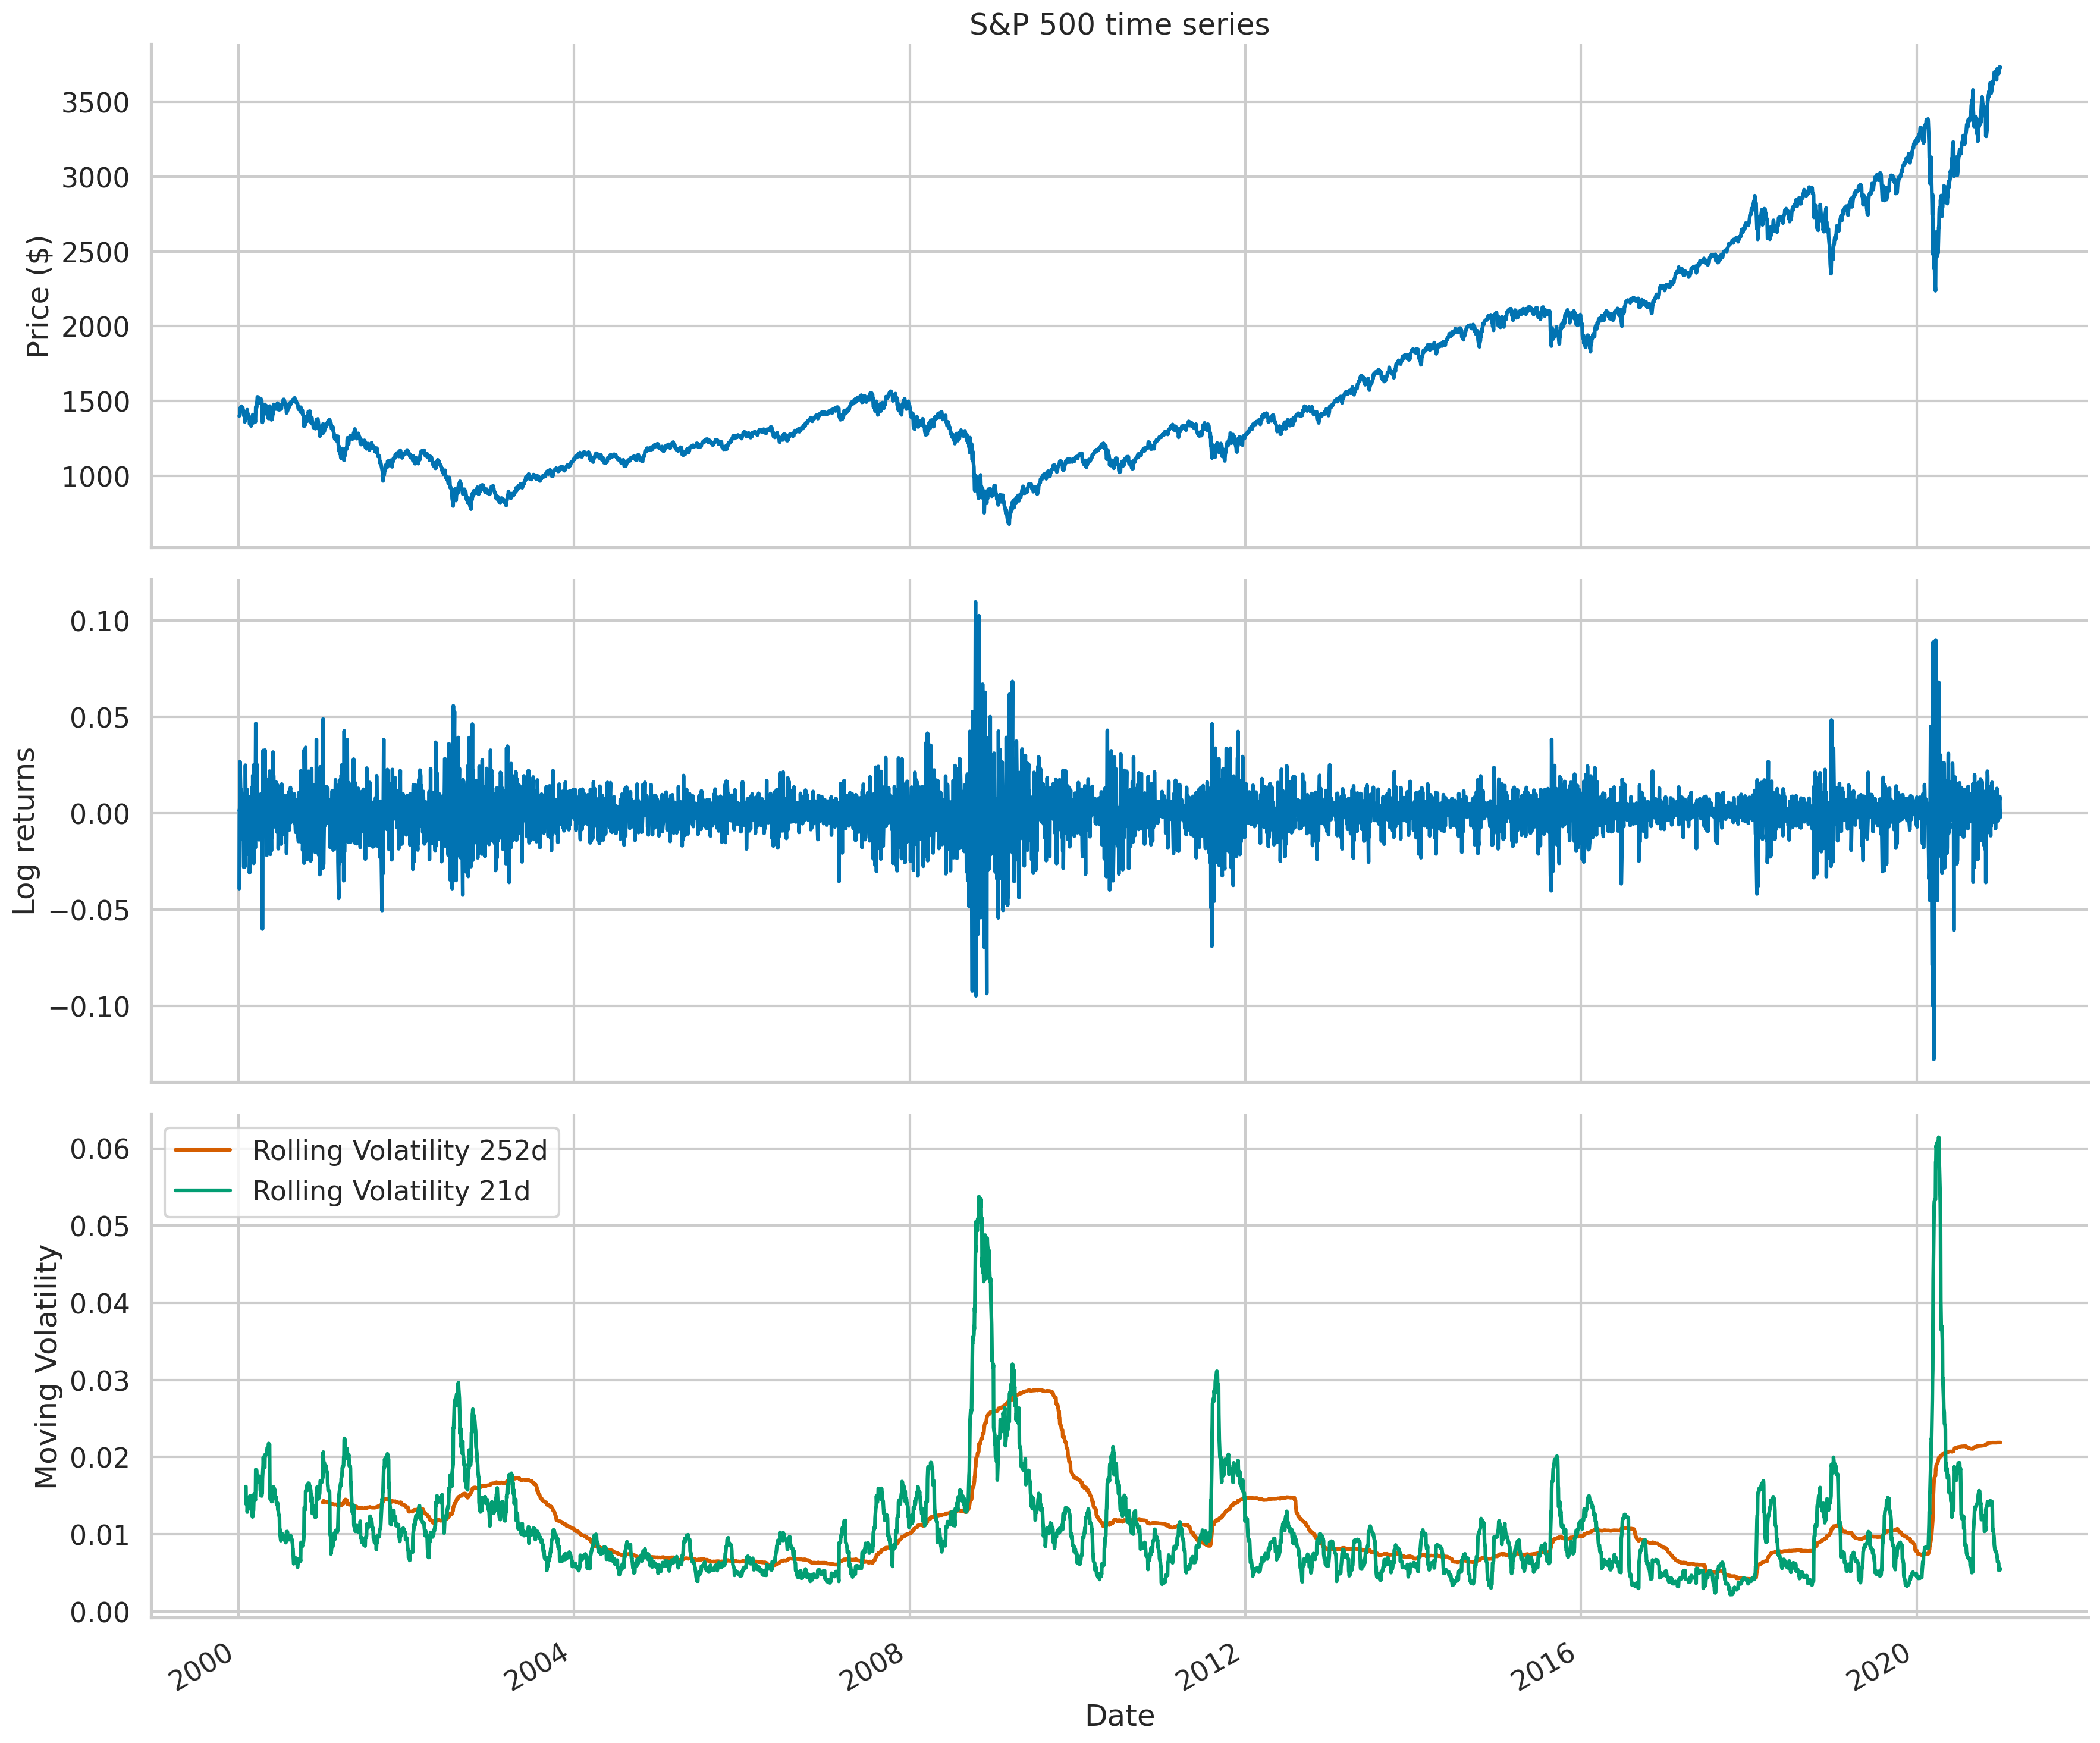

In [98]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), 
                       sharex=True)

df["adj_close"].plot(ax=ax[0])
ax[0].set(title="S&P 500 time series",
          ylabel="Price ($)")

df["log_rtn"].plot(ax=ax[1])
ax[1].set(ylabel="Log returns")

df["rolling_std_252"].plot(ax=ax[2], color="r", 
                           label="Rolling Volatility 252d")
df["rolling_std_21"].plot(ax=ax[2], color="g", 
                           label="Rolling Volatility 21d")
ax[2].set(ylabel="Moving Volatility",
          xlabel="Date")
ax[2].legend()

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_15", dpi=200);

- 그림 4.15에서 가격이 하락할 때 변동성이 증가하고, 가격이 상승할 때 변동성이 감소하는 패턴을 관찰할 수 있습니다. 이 관찰은 해당 현상의 정의와 일치합니다.

### There's more

- 레버리지 효과(사실 5)를 조사하는 또 다른 방법을 소개합니다. 이를 위해 VIX(CBOE 변동성 지수)를 사용합니다. VIX는 주식 시장의 변동성에 대한 기대치를 나타내는 인기 있는 지표로, S&P 500 지수 옵션 가격에 의해 유추됩니다. 우리는 다음 단계를 진행합니다:

1. Download and preprocess the prices of the S&P 500 and VIX:

In [99]:
df = yf.download(["^GSPC", "^VIX"], 
                 start="2000-01-01", 
                 end="2020-12-31",
                 progress=False)
df = df[["Adj Close"]]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={"^GSPC": "sp500", "^VIX": "vix"})

2. Calculate the log returns (we can just as well use percentage change-simple returns):

In [100]:
df["log_rtn"] = np.log(df["sp500"] / df["sp500"].shift(1))
df["vol_rtn"] = np.log(df["vix"] / df["vix"].shift(1))
df.dropna(how="any", axis=0, inplace=True)

3. Plot a scatterplot with the returns on the axes and fit a regression line to identify the trend:

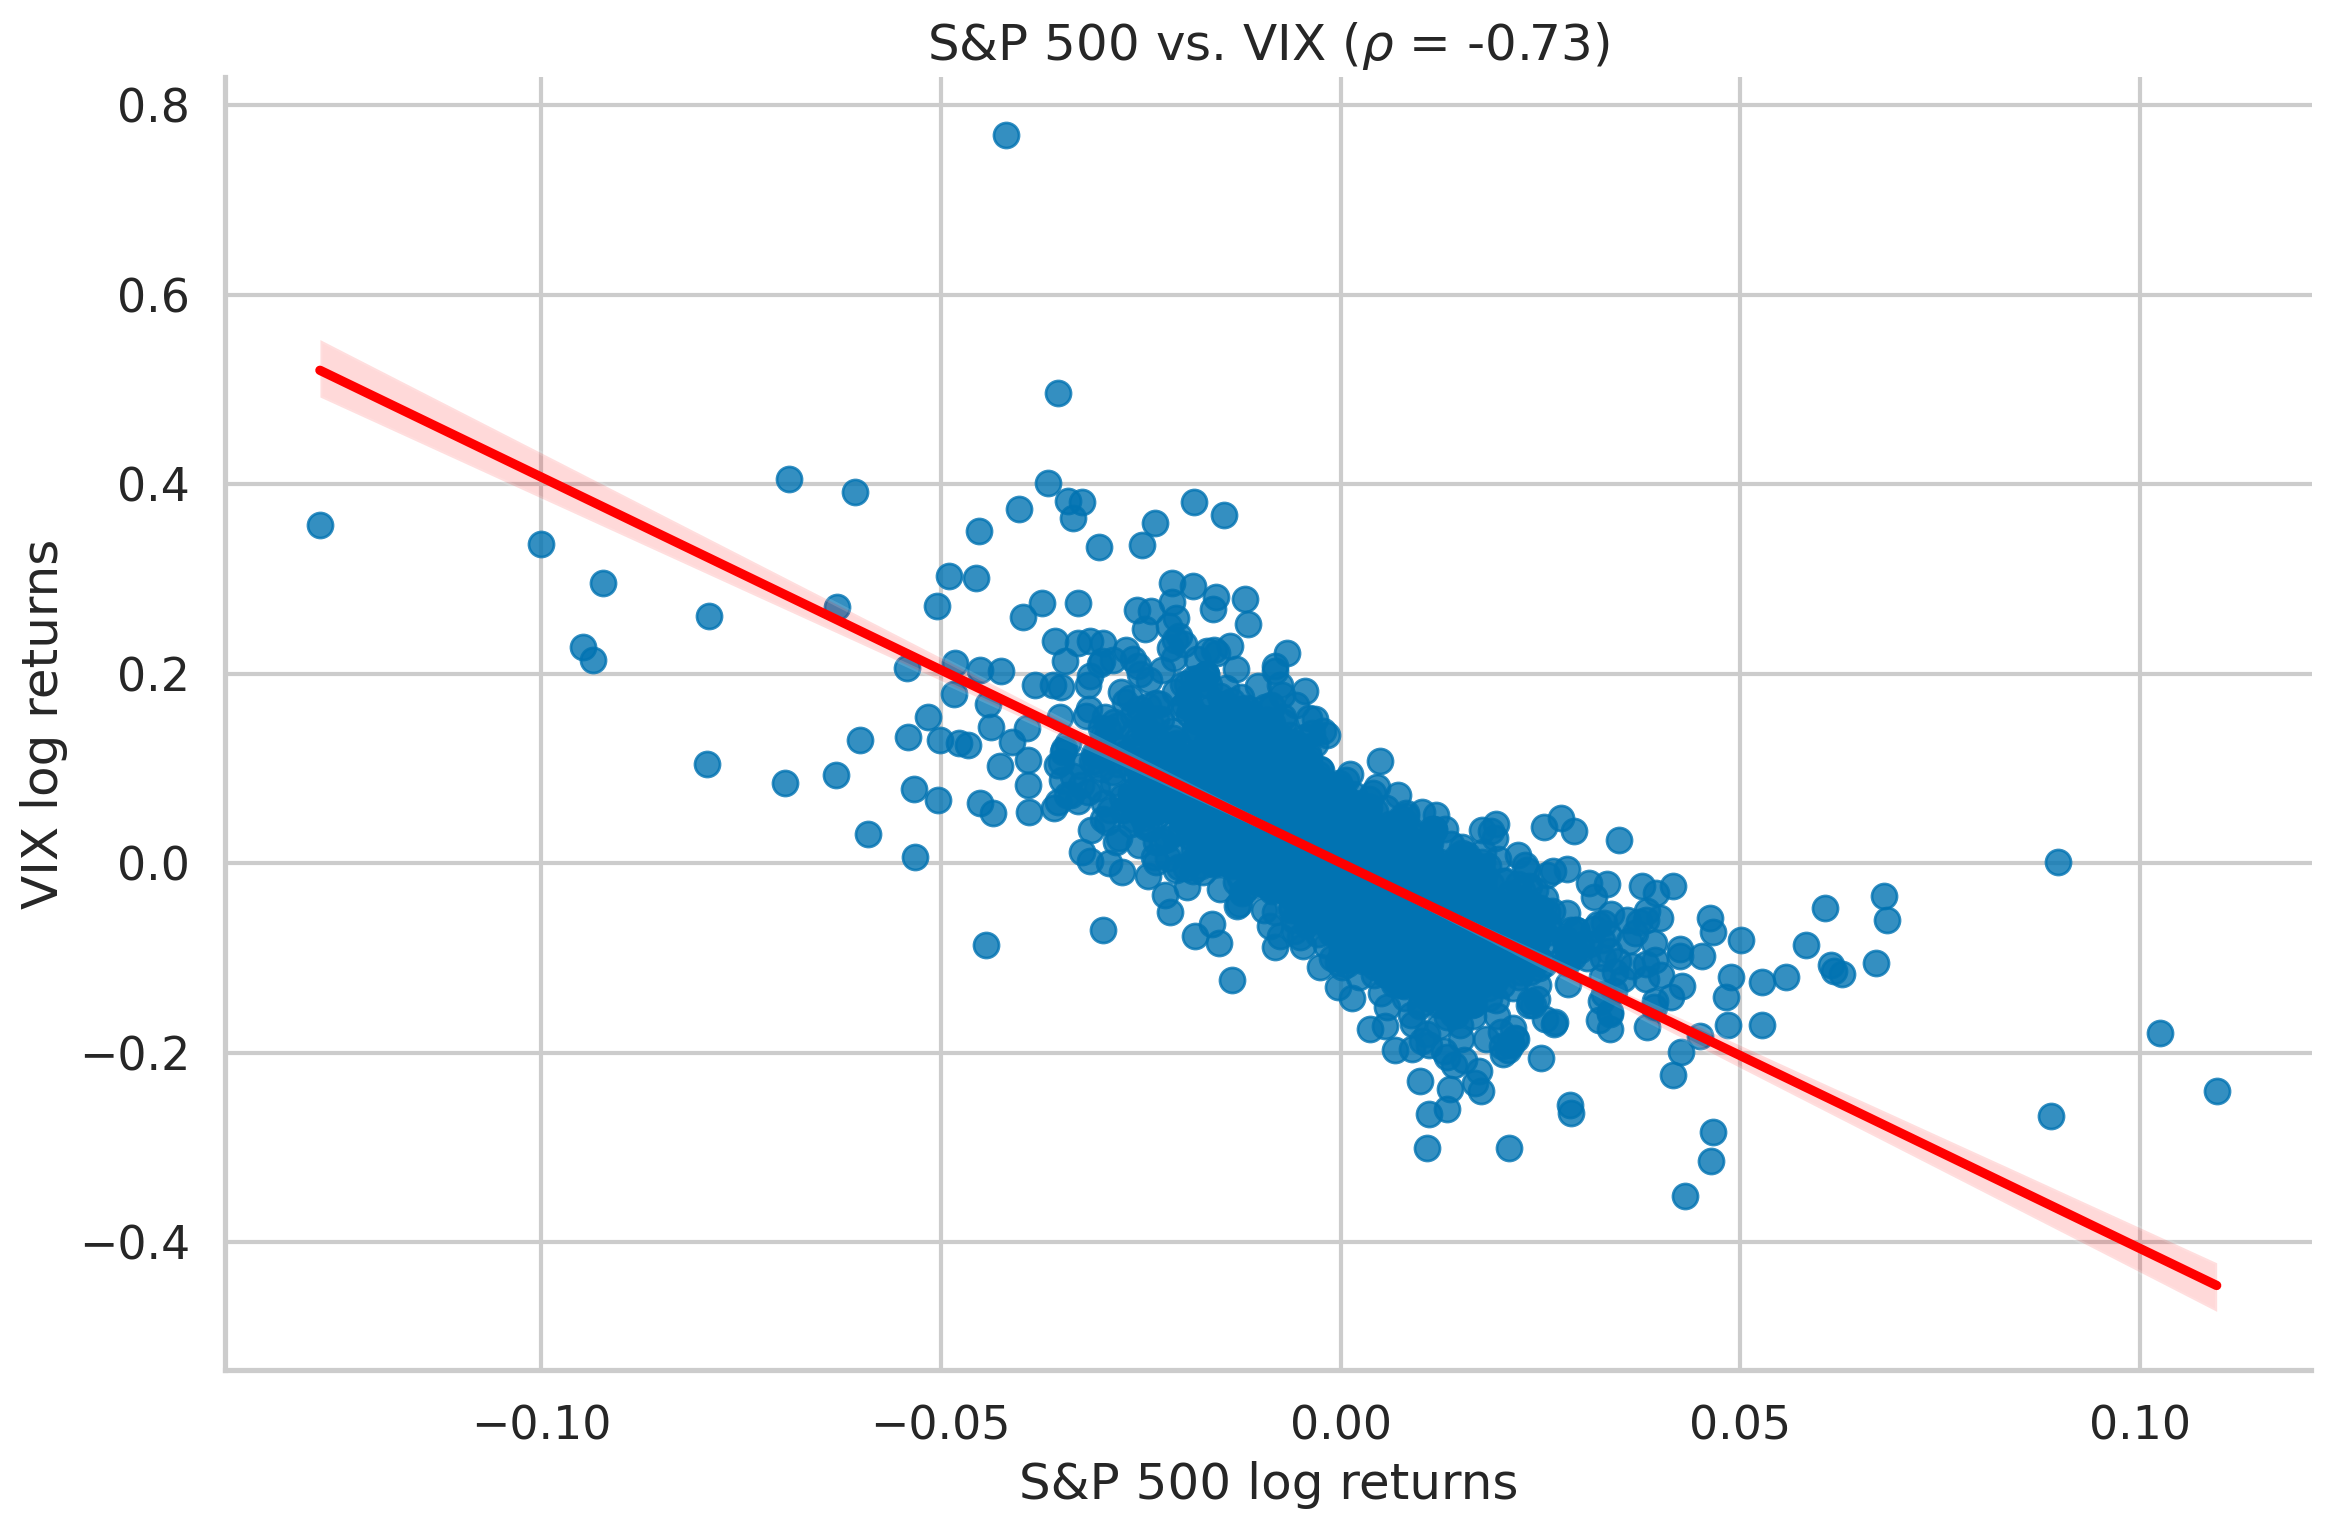

In [101]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)

ax = sns.regplot(x="log_rtn", y="vol_rtn", data=df, 
                 line_kws={"color": "red"})
ax.set(title=f"S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})",
       ylabel="VIX log returns",
       xlabel="S&P 500 log returns")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_16", dpi=200);

회귀선의 음의 기울기와 두 시계열 간의 강한 음의 상관관계는 수익률 시계열에서 레버리지 효과의 존재를 확인해줍니다.

**See also**

추가 정보는 다음을 참조하십시오:  
Cont, R. 2001. "Empirical properties of asset returns: stylized facts and statistical issues." Quantitative Finance, 1(2): 223

**Summary**

이 장에서는 다양한 알고리즘과 통계적 검정을 사용하여 금융 시계열에서 잠재적인 패턴과 문제(예: 이상치)를 자동으로 식별하는 방법을 배웠습니다. 이들을 통해 각 시계열을 수동으로 검사하는 대신, 임의의 자산 수에 대해 분석을 확장할 수 있습니다. 

또한 자산 수익률의 스타일화된 사실에 대해서도 설명했습니다. 이러한 사실을 이해하는 것은 매우 중요합니다. 많은 모델이나 전략이 관심 변수의 특정 분포를 가정하기 때문입니다. 가장 자주 가정되는 분포는 가우시안 분포입니다. 

그러나 보시다시피, 실제 자산 수익률은 정규 분포를 따르지 않습니다. 따라서 이러한 시계열을 분석할 때는 분석의 유효성을 확보하기 위해 특정한 주의가 필요합니다. 다음 장에서는 기술적 분석이라는 매우 인기 있는 분야를 탐구하고, 자산 가격 패턴 분석을 통해 어떤 통찰을 얻을 수 있는지 살펴보겠습니다.